In [39]:
#imports
import os
import scienceplots
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
from tqdm import tqdm

from mrmr import mrmr_regression

from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
torch.manual_seed(4000)
np.random.seed(42)

##### data preparation

In [40]:
#read data
X=pd.read_csv('.\\alternative_data_set\\X_diesel.csv',header=None)
Y=pd.read_csv('.\\alternative_data_set\\Y3_diesel.csv',header=None)

In [41]:
#remove missing values
X['target_variable']=Y[1]
X=X.dropna()
X=X.reset_index(drop=True)
Y=X.iloc[:,401]
X=X.iloc[:,:401]

In [42]:
X.shape

(395, 401)

In [43]:
#data split and normalisation
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

#train 0.8
#test 0.2

#norm
scaler_x = StandardScaler()
scaler_x.fit(x_train)
x_train=scaler_x.transform(x_train)
x_test=scaler_x.transform(x_test)

scaler_y=StandardScaler()
scaler_y.fit(y_train.values.reshape(-1,1))
y_train=scaler_y.transform(y_train.values.reshape(-1,1))
y_test=scaler_y.transform(y_test.values.reshape(-1,1))

In [44]:
x_train=pd.DataFrame(x_train)
y_train=pd.Series(y_train.ravel())

x_test=pd.DataFrame(x_test)
y_test=pd.Series(y_test.ravel())

##### NN functions

In [45]:
#convert, pandas to loader
def make_loader(X,y,batch):
    if not isinstance(X, pd.DataFrame):
        try:
            X = pd.DataFrame(X)
        except ValueError:
            print("X cannot be converted to a pandas DataFrame.")
    
    if not isinstance(y, pd.Series):
        try:
            y = pd.Series(y)
        except ValueError:
            print("X cannot be converted to a pandas Series.")        
            
    x_tensor=torch.tensor(X.values, dtype=torch.float32)
    y_tensor=torch.tensor(y.values, dtype=torch.float32)
    set_object=TensorDataset(x_tensor,y_tensor)
    loader_object=DataLoader(dataset=set_object,batch_size=batch)
    return loader_object

In [46]:
#NN class
class NeuralNetwork(nn.Module):
    def __init__(self,input_size):
        super(NeuralNetwork,self).__init__()
        
        self.linear1=nn.Linear(input_size,4)
        self.activation1=nn.ReLU()
        self.linear2=nn.Linear(4,4)
        self.activation2=nn.ReLU()
        self.linear3=nn.Linear(4,1)
        
    def forward(self,x):
        x=self.linear1(x)
        x=self.activation1(x)
        x=self.linear2(x)
        x=self.activation2(x)
        x=self.linear3(x)
        return x

In [47]:
#evaluate once
def evaluate(Loader, model, loss_fn):
    loss_sum=0
    with torch.no_grad():
        for batch, (X,y) in enumerate(Loader):
            pred=model(X)
            loss=loss_fn(pred,y.unsqueeze(1))
            loss_sum+=loss.item()
            
    loss_sum/=len(Loader)
    
    return loss_sum

In [48]:
#train and store all errors =)
def train_fn(TrainLoader, TestLoader, model, loss_fn, optimizer,epochs):
    train_loss_epochs=[]
    test_loss_epochs=[]
    
    model.train() 
    
    for epoch in range(epochs):
        #train for every example in the dataloader
        for X_train,y_train in TrainLoader:
            
            pred_train=model(X_train)
            loss_train=loss_fn(pred_train,y_train.unsqueeze(1))
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
    
        loss_train_curr_epoch=evaluate(TrainLoader,model,loss_fn)
        train_loss_epochs.append(loss_train_curr_epoch)
       
        loss_test_curr_epoch=evaluate(TestLoader,model,loss_fn)
        test_loss_epochs.append(loss_test_curr_epoch)
        
    return model, train_loss_epochs, test_loss_epochs

In [49]:
#train and not store all errors, i will use this one on the building of the tables, will speed up things...
def train_fn_no_loss(TrainLoader, model, loss_fn, optimizer,epochs):
    model.train() 
    for epoch in range(epochs):
        #train for every example in the dataloader
        for X_train,y_train in TrainLoader:
            
            pred_train=model(X_train)
            loss_train=loss_fn(pred_train,y_train.unsqueeze(1))
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
        
    return model

In [50]:
#train a single epoch
def train_one_epoch(TrainLoader, model, loss_fn, optimizer):
    model.train() 
    #train for every example in the dataloader
    for X_train,y_train in TrainLoader:
            
        pred_train=model(X_train)
        loss_train=loss_fn(pred_train,y_train.unsqueeze(1))
            
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
    return model

In [51]:
#early stop criterion
class EarlyStopper:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.last_loss = float('inf')

    def early_stop(self, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
        elif loss > self.last_loss:  # Spike detection
            pass  # Do nothing if a spike is detected
        else:
            self.counter += 1  # Increment if no improvement or no spike
            if self.counter >= self.patience:
                return True
        
        self.last_loss = loss
        return False

In [52]:
#train and store all errors =)
def train_early_stop(TrainLoader, TestLoader, model, loss_fn, optimizer,max_epochs):
    train_loss_epochs=[]
    test_loss_epochs=[]
    
    model.train() 
    
    early_stopper = EarlyStopper(patience=25, min_delta=0.001)
    
    for epoch in range(max_epochs):
        #train for every example in the dataloader
        model=train_one_epoch(TrainLoader=TrainLoader, model=model, loss_fn=loss_fn, optimizer=optimizer)
    
        loss_train_curr_epoch=evaluate(TrainLoader,model,loss_fn)
        train_loss_epochs.append(loss_train_curr_epoch)
       
        loss_test_curr_epoch=evaluate(TestLoader,model,loss_fn)
        test_loss_epochs.append(loss_test_curr_epoch)
        
        if early_stopper.early_stop(loss=loss_train_curr_epoch):        
            break
        
    return model, train_loss_epochs, test_loss_epochs

In [53]:
#train and not store errors
def train_early_stop_no_loss(TrainLoader, model, loss_fn, optimizer,max_epochs):
    model.train() 
    
    early_stopper = EarlyStopper(patience=25, min_delta=0.001)
    
    for epoch in range(max_epochs):
        #train for every example in the dataloader
        model=train_one_epoch(TrainLoader=TrainLoader, model=model, loss_fn=loss_fn, optimizer=optimizer)
       
        loss_train_curr_epoch=evaluate(TrainLoader,model,loss_fn)
        
        if early_stopper.early_stop(loss=loss_train_curr_epoch):             
            break
        
    return model, epoch

In [54]:
#simple function to initialize parameters, also work as a 'reset' of parameters
def ini_model(input,epochs=200):
    torch.manual_seed(42)
    model=NeuralNetwork(input_size=input)
    loss_fn=nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),
                         lr=0.001,
                         weight_decay=0)
    return model,loss_fn,optimizer,epochs

##### NN loss plot example

In [59]:
train_loader=make_loader(X=x_train,y=y_train,batch=2000)
test_loader=make_loader(X=x_test,y=y_test,batch=2000)

model,loss_fn,optimizer,epochs=ini_model(input=x_test.shape[1])

In [17]:
mi_scores=mutual_info_regression(x_train,y_train,n_neighbors=3)
important_idx=pd.Series(mi_scores).sort_values(ascending=False).head(200).index
x_train_selected=x_train[important_idx.sort_values()]
x_test_selected=x_test[important_idx.sort_values()]


In [30]:
model, train_loss, test_loss=train_fn(TrainLoader=train_loader,
                                      TestLoader=test_loader, 
                                      model=model, 
                                      loss_fn=loss_fn, 
                                      optimizer=optimizer,
                                      epochs=6000)

In [60]:
model, train_loss, test_loss=train_early_stop(TrainLoader=train_loader,
                                             TestLoader=test_loader,
                                             model=model,
                                             loss_fn=loss_fn,
                                             optimizer=optimizer,
                                             max_epochs=6000)

In [61]:
parou_no=len(train_loss)
parou_no

2304

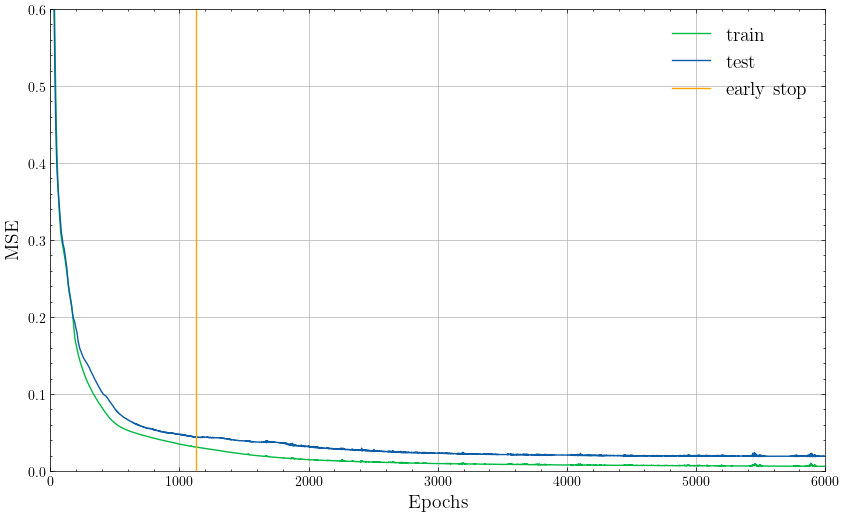

In [32]:
import scienceplots
plt.style.use('science')
plt.figure(figsize=(10,6))

plt.plot(np.arange(len(train_loss)),train_loss,label='train',color='C1')
plt.plot(np.arange(len(test_loss)),test_loss,label='test',color='C0')
plt.axvline(x=parou_no,color='orange',label='early stop')
plt.legend(fontsize=14)
plt.xlim(0,6000)
plt.ylim(0,0.6)


plt.xlabel('Epochs',fontsize=14)
plt.ylabel('MSE',fontsize=14)
plt.grid()


plt.savefig('C:\\Users\\lucas\\Downloads\\feature_selec_learning_curve_diff.pdf', format='pdf', bbox_inches='tight')

##### NN permutation importance functions

In [83]:
#permutation importance from scikitlearn internally uses the predict function and checks for the presence
#of the fit function. if i feed my pytorch model inside a wrapper scikitlearn allows me tu use it's function =)
class PyTorchRegressorWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        #this function only needs to exhist to fulfill API contract with scikitlearn
        pass

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            #convert to numpy as needed
            if isinstance(X, pd.DataFrame):
                X = X.to_numpy()

            X_tensor = torch.tensor(X, dtype=torch.float32)
            predictions = self.model(X_tensor).numpy()
        return predictions

In [84]:
#function to evaluate permutation importance, evaluate on every fold, also stores learning curves...
def permutation_importance_loss_nn(X_train,y_train,k_folds):
    
    if not isinstance(X_train, pd.DataFrame):
        try:
            X_train = pd.DataFrame(X_train)
        except ValueError:
            print("X cannot be converted to a pandas DataFrame.")
    
    if not isinstance(y_train, pd.Series):
        try:
            y_train = pd.Series(y_train)
        except ValueError:
            print("X cannot be converted to a pandas Series.")        
               
    kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)

    cross_importances=np.zeros((X_train.shape[1],kfold.n_splits))

    train_loss_fold=[[],[],[],[],[]]
    val_loss_fold=[[],[],[],[],[]]
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        
        x_train_fold=X_train.iloc[np.sort(train_idx)]
        y_train_fold=y_train.iloc[np.sort(train_idx)]
        x_val_fold=X_train.iloc[np.sort(val_idx)]
        y_val_fold=y_train.iloc[np.sort(val_idx)]
        
        train_loader_fold=make_loader(X=x_train_fold,y=y_train_fold,batch=1000)
        test_loader_fold=make_loader(X=x_val_fold,y=y_val_fold,batch=1000)

        model,loss_fn,optimizer,epochs=ini_model(input=401) #epochs defined inside function
        
        model, train_loss_fold[fold], val_loss_fold[fold]=train_early_stop(TrainLoader=train_loader_fold,
                                                                            TestLoader=test_loader_fold,
                                                                            model=model,
                                                                            loss_fn=loss_fn,
                                                                            optimizer=optimizer,
                                                                            max_epochs=6000)
        
        # pass model trough wrapper
        model_wrapper = PyTorchRegressorWrapper(model=model)

        # permutation importance with the wrapper instance
        results = permutation_importance(model_wrapper,
                                        x_val_fold,
                                        y_val_fold,
                                        n_repeats=30,
                                        random_state=42,
                                        n_jobs=4,
                                        scoring='neg_mean_squared_error')
        
        cross_importances[:,fold]=results.importances_mean
        
    return cross_importances, train_loss_fold, val_loss_fold


In [85]:
#this function returns the indexes to slice the n most important features
def perm_imp_get_topn_indexes(perm_imp_output,top_n):
    
    best_n=perm_imp_output.sort_values().head(top_n).index
    
    return best_n

In [86]:
def build_table_nn_perm_imp(x_train,y_train,x_test,y_test,step,perm_imp_array,k_folds):
    #here i used the terms calibration and train somewhat interchangeably
    #the idea is that the complete train set without fold separation to be called calibration
    #the fold used to generate the model is train and the fold used to validade is validation...
    columns=['train mse','train std','val mse','val std','calibration mse','test mse','epochs']
    stored = pd.DataFrame(columns=columns)

    for features in tqdm(np.arange(401,390,-step)):
        
        important_idx=perm_imp_get_topn_indexes(perm_imp_output=perm_imp_array,
                                                top_n=features)
    
        x_train_reduced=x_train[important_idx.sort_values()]
        x_test_reduced=x_test[important_idx.sort_values()]
        
        kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)
        
        train_mse_fold=[]
        val_mse_fold=[]
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train_reduced)):
        
            x_train_fold=x_train_reduced.iloc[np.sort(train_idx)]
            y_train_fold=y_train.iloc[np.sort(train_idx)]
            x_val_fold=x_train_reduced.iloc[np.sort(val_idx)]
            y_val_fold=y_train.iloc[np.sort(val_idx)]
            
            train_loader_fold=make_loader(X=x_train_fold,y=y_train_fold,batch=1000)
            val_loader_fold=make_loader(X=x_val_fold,y=y_val_fold,batch=1000)

            model,loss_fn,optimizer, _ =ini_model(input=features)#epochs defined inside function
           
            model,_ =train_early_stop_no_loss(TrainLoader=train_loader_fold,
                                           model=model,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           max_epochs=6000)
            
            train_loss_single_fold=evaluate(Loader=train_loader_fold, model=model, loss_fn=loss_fn)
            val_loss_single_fold=evaluate(Loader=val_loader_fold, model=model, loss_fn=loss_fn)
            
            train_mse_fold.append(train_loss_single_fold)
            val_mse_fold.append(val_loss_single_fold)
        
        train_loader=make_loader(X=x_train_reduced,y=y_train,batch=1000)
        test_loader=make_loader(X=x_test_reduced,y=y_test,batch=1000)

        model,loss_fn,optimizer, _ =ini_model(input=features) #definedinside function
        model, epoch=train_early_stop_no_loss(TrainLoader=train_loader_fold,
                                           model=model,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           max_epochs=6000)
                
        train_loss=evaluate(Loader=train_loader, model=model, loss_fn=loss_fn)
        val_loss=evaluate(Loader=test_loader, model=model, loss_fn=loss_fn)
        
        #['avg train mse','std train mse,'avg val mse','std val mse','calibration mse','test mse']
        avg_loss_train_fold=np.mean(train_mse_fold)
        std_loss_train_fold=np.std(train_mse_fold)
        avg_loss_val_fold=np.mean(val_mse_fold)
        std_loss_val_fold=np.std(val_mse_fold)
        
        stored.loc[features] = [avg_loss_train_fold,
                                std_loss_train_fold,
                                avg_loss_val_fold,
                                std_loss_val_fold,
                                train_loss,
                                val_loss,
                                epoch]
            
    return stored

In [87]:
#check consistency by intersection
def check_intersections(df,top_n):
    col=df.columns
    matrix=np.zeros((5,5),dtype=float)
    top_idx=[]
    for i in range(1,6):
        top_idx.append(set(perm_imp_get_topn_indexes(perm_imp_output=df['fold'+str(i)],top_n=top_n)))
        
    for i in range(0,5):
        for j in range(0,5):
            if j<=j:
                intersec_acc=len(top_idx[i] & top_idx[j])/top_n
                matrix[i,j]=intersec_acc
                matrix[j,i]=intersec_acc
    #eturn top_idx
    return pd.DataFrame(matrix, index=col, columns=col)

##### NN permutation importance evaluation

In [117]:
importances,train_loss_list,val_loss_list=permutation_importance_loss_nn(X_train=x_train,
                                                                      y_train=y_train,
                                                                      k_folds=5)

In [118]:
#pre processing necessary, assume the correct ranking of each feature is the median value among folds...
importance_rank=pd.DataFrame(importances).rank(ascending=False)
importance_rank_named=importance_rank.rename(columns={0:'fold1',1:'fold2',2:'fold3',3:'fold4',4:'fold5'})
#importance_overall_rank=importance_rank_named.mean(axis=1)
importance_overall_rank=importance_rank_named.median(axis=1) #using median is more robust to outliers 

In [119]:
#check consistency by intersection
check_intersections(importance_rank_named,200)

,fold1,fold2,fold3,fold4,fold5
fold1,1.000,0.655,0.645,0.685,0.74
fold2,0.655,1.000,0.670,0.580,0.66
fold3,0.645,0.670,1.000,0.595,0.75
fold4,0.685,0.580,0.595,1.000,0.68
fold5,0.740,0.660,0.750,0.680,1.00


In [123]:
table = build_table_nn_perm_imp(x_train=x_train,
                    y_train=y_train,
                    x_test=x_test,
                    y_test=y_test,
                    step=10,
                    perm_imp_array=importance_overall_rank,
                    k_folds=5)

100%|██████████| 2/2 [01:57<00:00, 58.77s/it]


In [125]:
table

,train mse,train std,val mse,val std,calibration mse,test mse,epochs
401,0.032728,0.006174,0.075071,0.019777,0.044463,0.070941,2261.0
391,0.029294,0.003969,0.074817,0.025039,0.034534,0.059235,798.0


In [27]:
#write in memory...
df=pd.DataFrame(table)
dir_path='C:\\Users\\lucas\\Downloads'

os.makedirs(dir_path,exist_ok=True)
file_path=os.path.join(dir_path,'table_dataframe_NN_permI_150_to_1')
df.to_csv(file_path, index=False)

In [161]:
df1=pd.read_csv('C:\\Users\\lucas\\Downloads\\table_dataframe_NN_permI.csv')
df2=pd.read_csv('C:\\Users\\lucas\\Downloads\\table_dataframe_NN_permI_150_to_1.csv')


In [162]:
#necessary for correct plotting
b=np.arange(150,1,-1)
a=np.arange(401,150,-10)

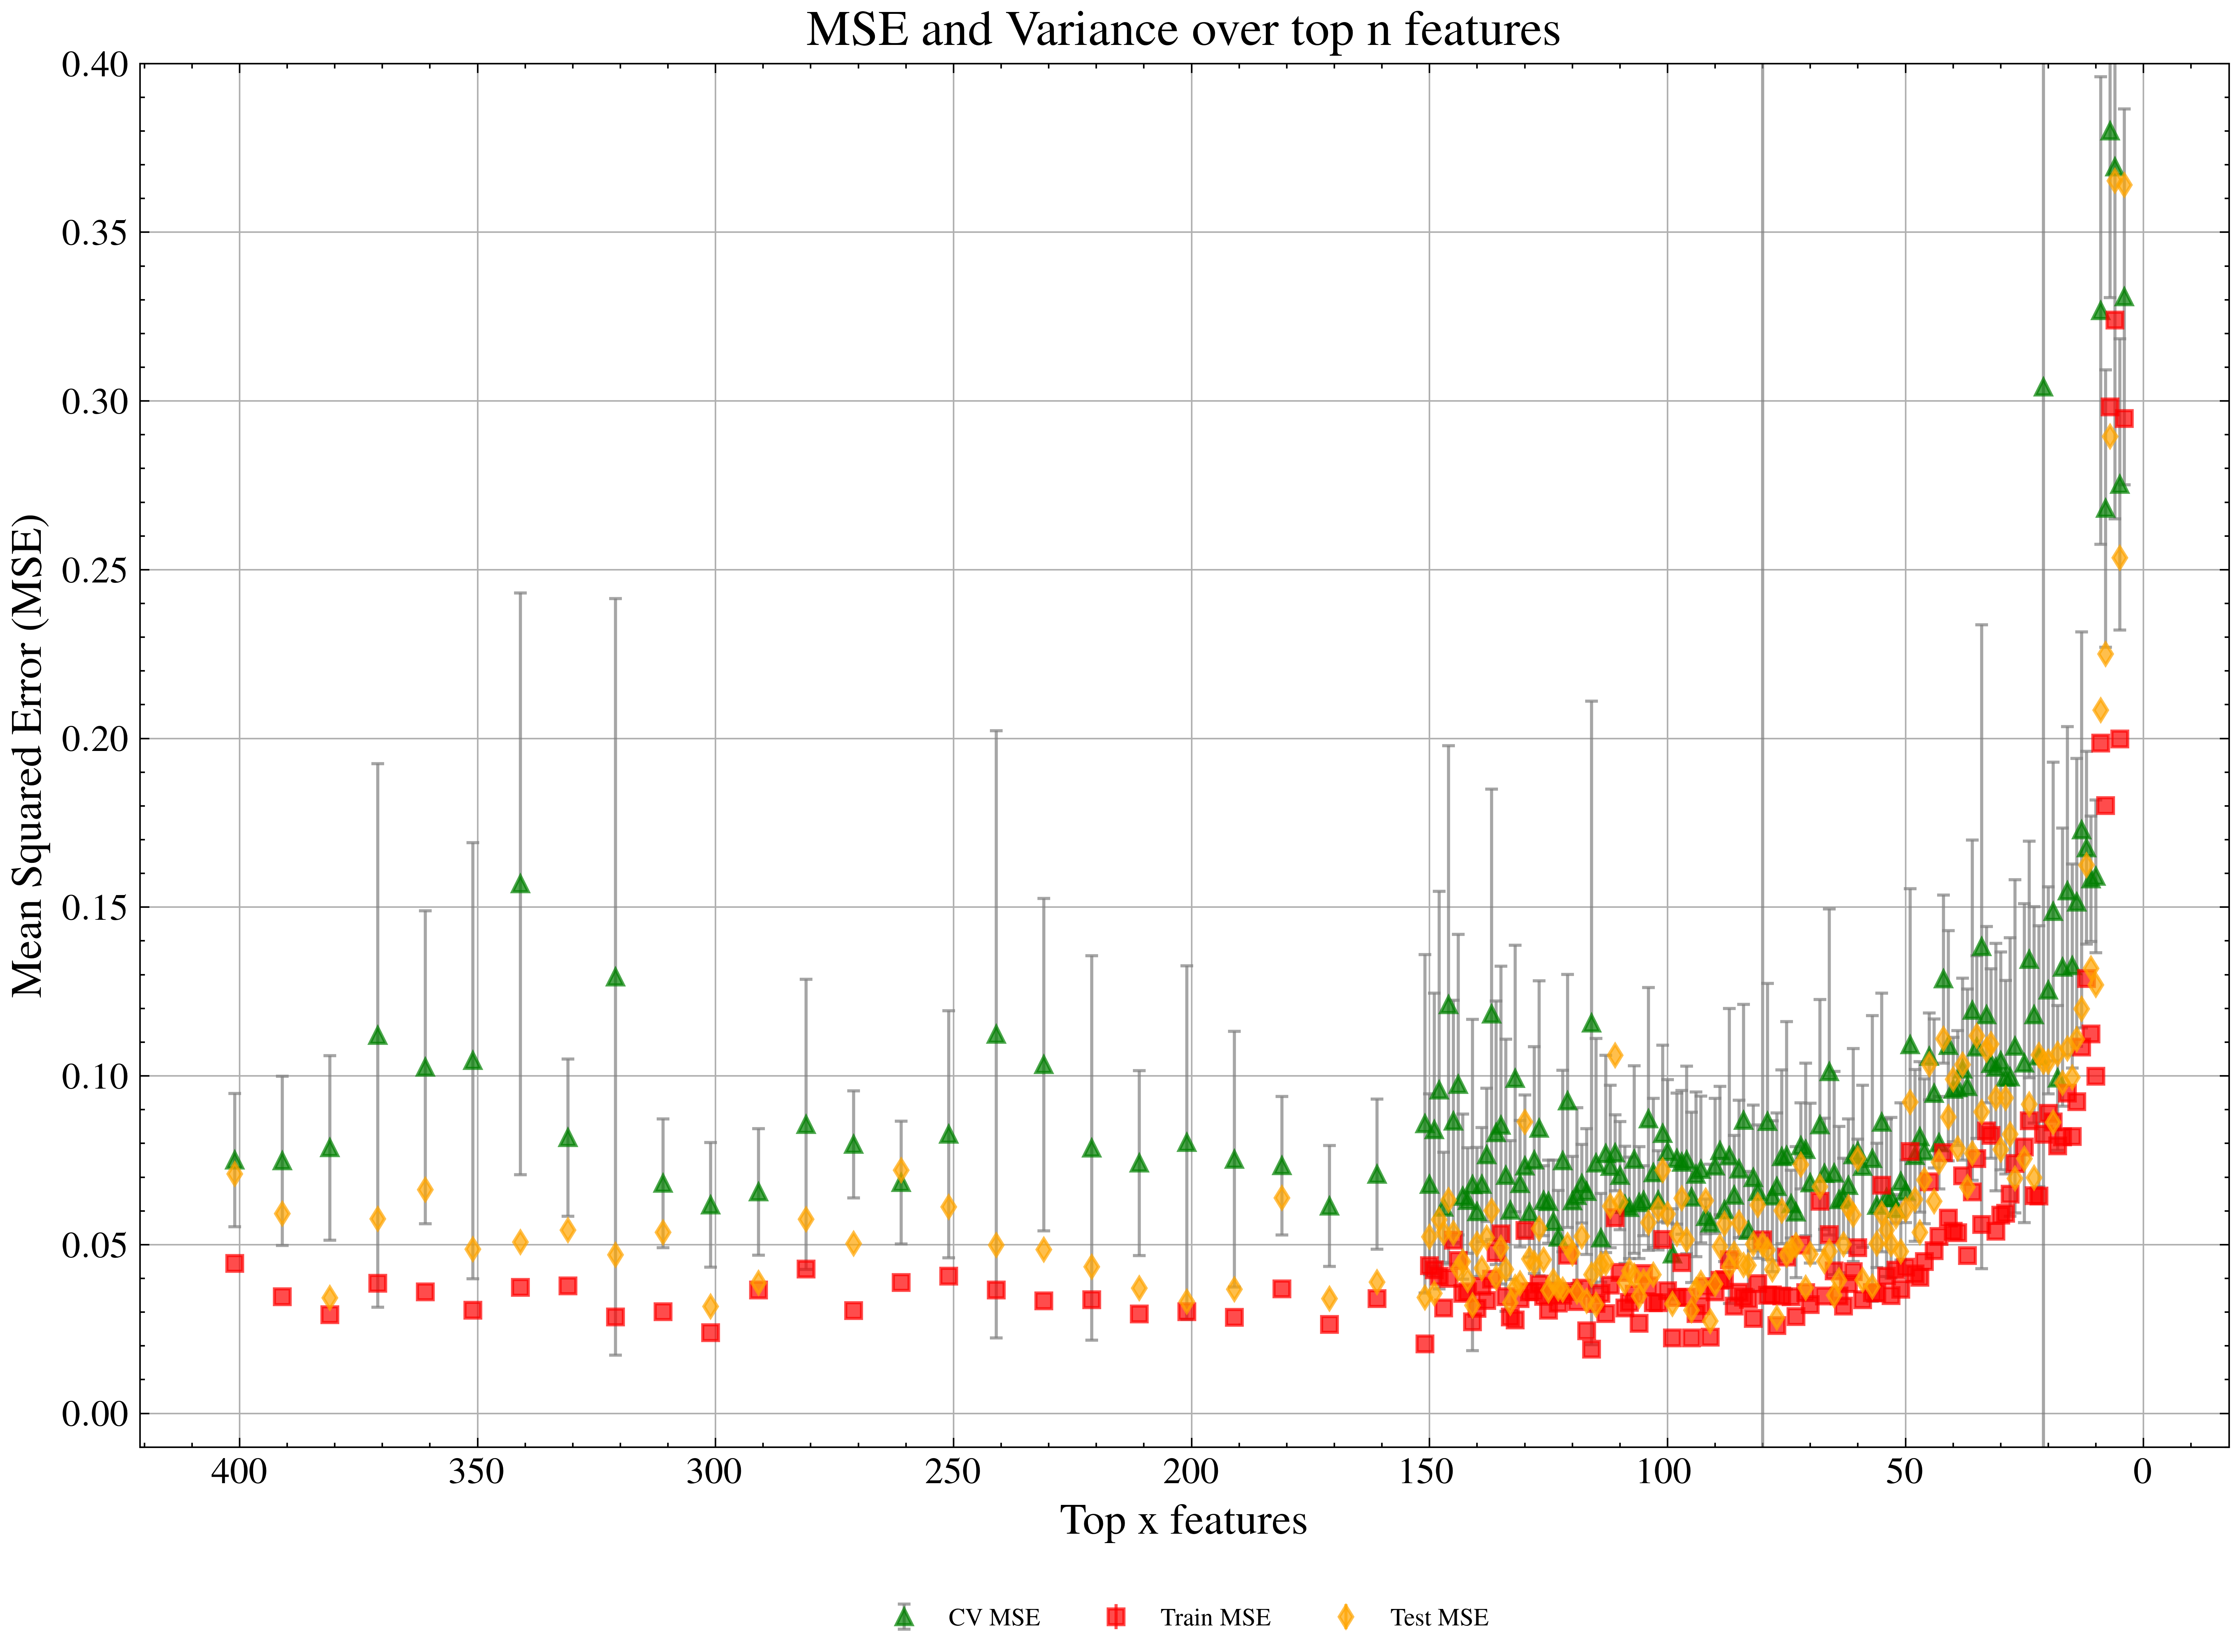

In [167]:
import scienceplots
plt.style.use('science')
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

#plt.errorbar(df1.index[::-1], df1['train mse'][::-1], yerr=df1['train std'][::-1], fmt='o', markersize=5, capsize=2, label='Train MSE', color='blue', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(a, df1['val mse'][::1], yerr=df1['val std'][::1], fmt='^', markersize=5, capsize=2, label='CV MSE', color='green', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(a, df1['calibration mse'][::1], yerr=0, fmt='s', markersize=5, label='Train MSE', color='red', alpha=0.7, linestyle='')
plt.errorbar(a, df1['test mse'][::1], yerr=0, fmt='d', markersize=5, label='Test MSE', color='orange', alpha=0.7, linestyle='')

plt.errorbar(b, df2['val mse'][::1], yerr=df2['val std'][::1], fmt='^', markersize=5, capsize=2, color='green', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(b, df2['calibration mse'][::1], yerr=0, fmt='s', markersize=5, color='red', alpha=0.7, linestyle='')
plt.errorbar(b, df2['test mse'][::1], yerr=0, fmt='d', markersize=5, color='orange', alpha=0.7, linestyle='')
plt.xlabel('Top x features', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.title('MSE and Variance over top n features', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4)
plt.ylim(-0.01, 0.4)
plt.gca().invert_xaxis()  # Keep the x-axis inverted


In [ ]:
topX=101
important_idx=perm_imp_get_topn_indexes(perm_imp_output=importance_overall_rank,
                                        top_n=topX)
    
x_train_important=x_train[important_idx.sort_values()]
x_test_important=x_test[important_idx.sort_values()]

train_loader_important=make_loader(x_train_important,y_train,100)
test_loader_important=make_loader(x_test_important,y_test,100)

model,loss_fn,optimizer,epochs=ini_model(input=topX,epochs=200)
model, train_loss, test_loss=train_early_stop(TrainLoader=train_loader_important,
                                                                            TestLoader=test_loader_important,
                                                                            model=model,
                                                                            loss_fn=loss_fn,
                                                                            optimizer=optimizer,
                                                                            max_epochs=6000)

Text(0, 0.5, 'MSE')

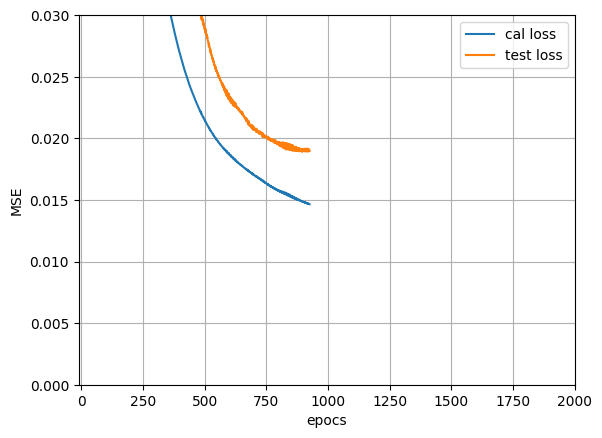

In [ ]:
plt.plot(np.arange(len(train_loss)),train_loss,label='cal loss')
plt.plot(np.arange(len(test_loss)),test_loss,label='test loss')
plt.legend()
plt.xlim(-10,2000)
plt.ylim(0,0.03)
plt.grid()
plt.xlabel('epocs')
plt.ylabel('MSE')

##### NN permutation importance loss on kfolds

In [153]:
importances,train_loss_list,val_loss_list=permutation_importance_loss(X_train=x_train,
                                                                      y_train=y_train,
                                                                      k_folds=5)

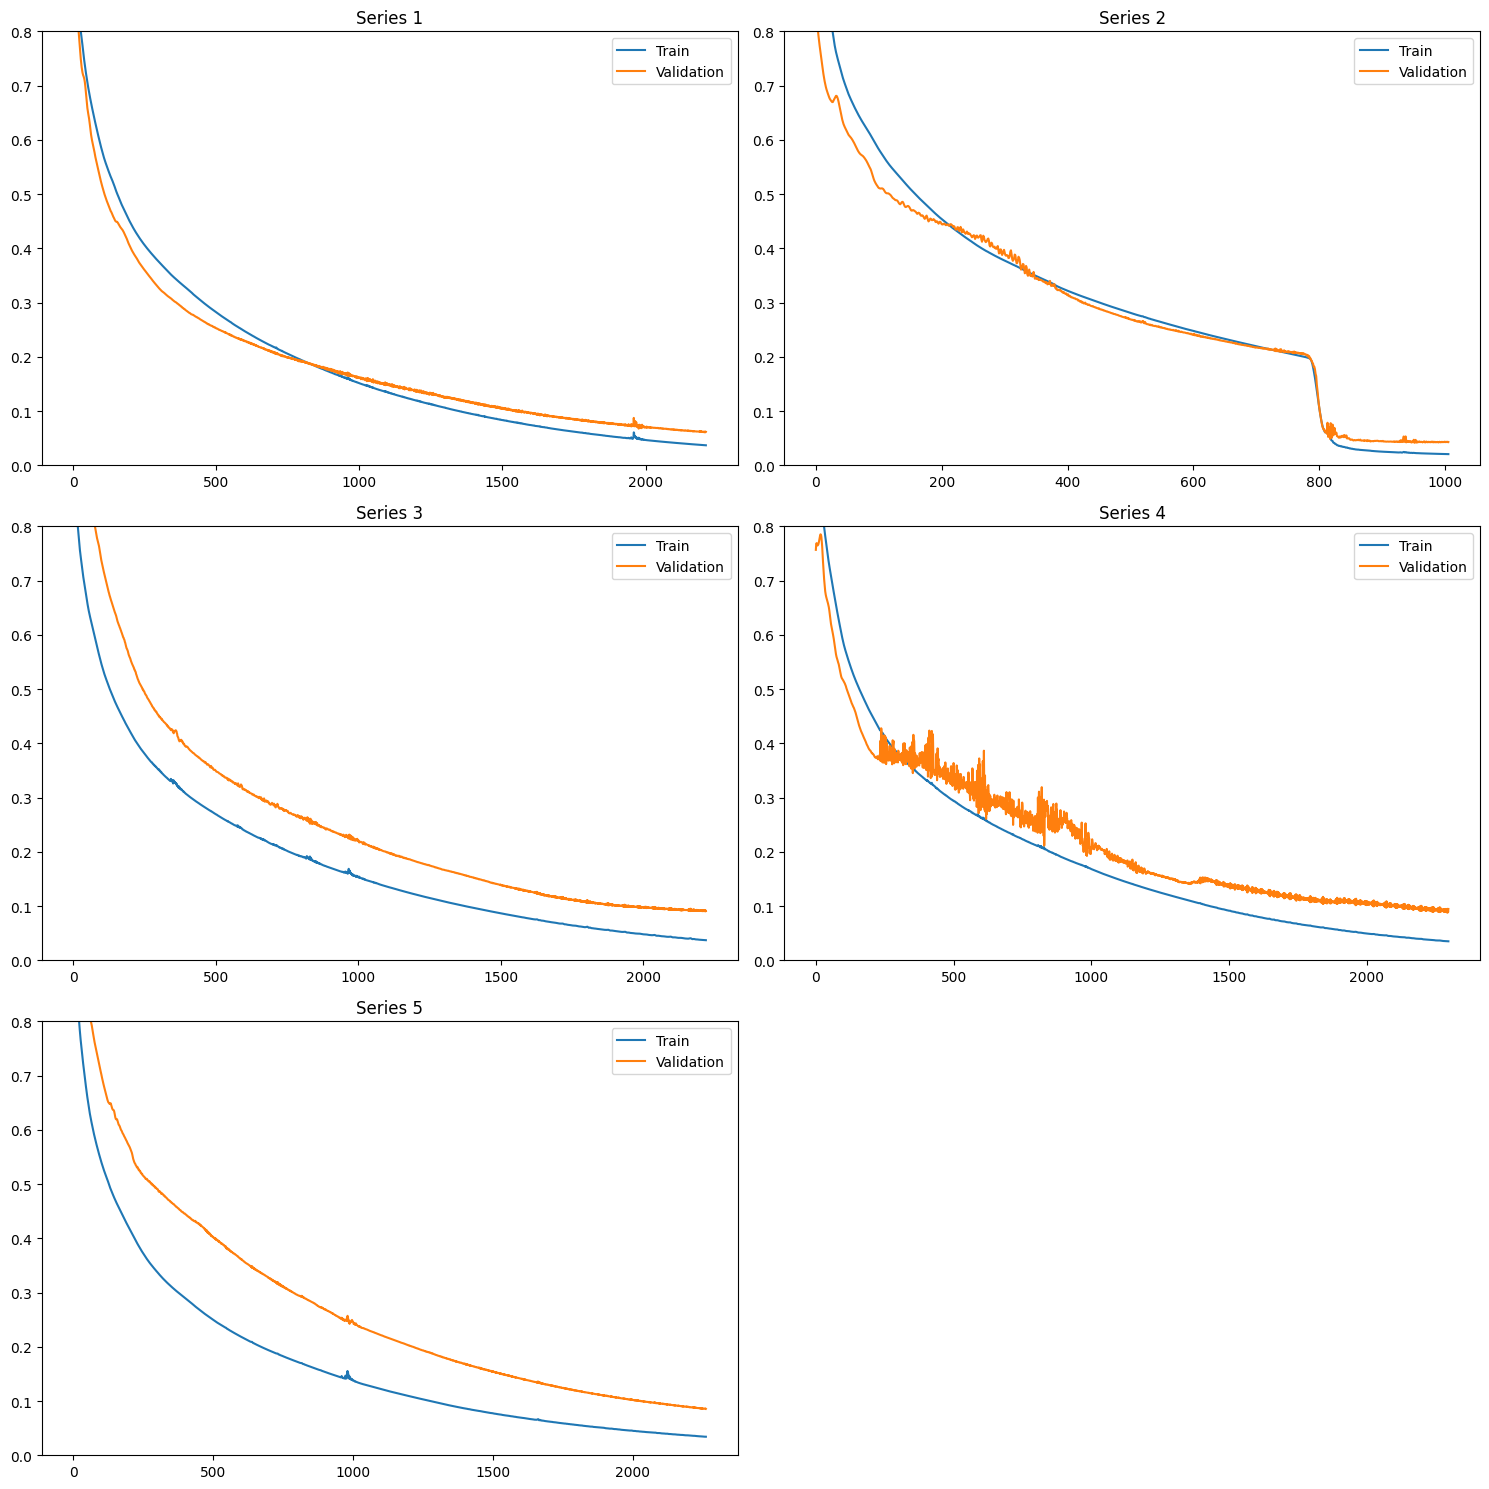

In [154]:
#loss plots on different folds
fig, axs = plt.subplots(3, 2, figsize=(15, 15))  # 3 rows, 2 columns

# flat so i can use indexing
axs_flat = axs.flatten()

for i in range(5):
    # Plot on subplot i
    axs_flat[i].plot(np.arange(len(train_loss_list[i])), train_loss_list[i], label='Train')
    axs_flat[i].plot(np.arange(len(val_loss_list[i])), val_loss_list[i], label='Validation')
    axs_flat[i].legend()
    axs_flat[i].set_title(f'Series {i+1}')
    axs_flat[i].set_ylim([0, 0.8])

# Hide the last subplot as it's unused
axs_flat[-1].axis('off')

plt.tight_layout()
plt.show()

##### NN minimum redunrance maximum relevance (mRMR)

In [155]:
def build_table_mrmr_nn(x_train,y_train,x_test,y_test,step,k_folds):
    #here i used the terms calibration and train somewhat interchangeably
    #the idea is that the complete train set without fold separation to be called calibration
    #the fold used to generate the model is train and the fold used to validade is validation...
    columns=['train mse','train std','val mse','val std','calibration mse','test mse','epochs']
    stored = pd.DataFrame(columns=columns)

    selected_features=mrmr_regression(X=x_train,
                                      y=y_train,
                                      K=401)

    for features in tqdm(range(401, 390, -step)):
        
        important_idx=selected_features[0:features]
    
        important_idx.sort()
    
        x_train_selected=x_train[important_idx]
        x_test_selected=x_test[important_idx]
        
        kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)
        
        train_mse_fold=[]
        val_mse_fold=[]
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train)):
        
            x_train_fold=x_train_selected.iloc[np.sort(train_idx)]
            y_train_fold=y_train.iloc[np.sort(train_idx)]
            x_val_fold=x_train_selected.iloc[np.sort(val_idx)]
            y_val_fold=y_train.iloc[np.sort(val_idx)]
            
            train_loader_fold=make_loader(X=x_train_fold,y=y_train_fold,batch=1000)
            val_loader_fold=make_loader(X=x_val_fold,y=y_val_fold,batch=1000)

            model,loss_fn,optimizer, _ =ini_model(input=features)#epochs defined inside function

            model,_ =train_early_stop_no_loss(TrainLoader=train_loader_fold,
                                           model=model,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           max_epochs=6000)
            
            train_loss_single_fold=evaluate(Loader=train_loader_fold, model=model, loss_fn=loss_fn)
            val_loss_single_fold=evaluate(Loader=val_loader_fold, model=model, loss_fn=loss_fn)
            
            train_mse_fold.append(train_loss_single_fold)
            val_mse_fold.append(val_loss_single_fold)
        
        train_loader=make_loader(X=x_train_selected,y=y_train,batch=1000)
        test_loader=make_loader(X=x_test_selected,y=y_test,batch=1000)

        model,loss_fn,optimizer, _ =ini_model(input=features) #definedinside function
        model, epoch=train_early_stop_no_loss(TrainLoader=train_loader_fold,
                                           model=model,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           max_epochs=6000)
                
        train_loss=evaluate(Loader=train_loader, model=model, loss_fn=loss_fn)
        val_loss=evaluate(Loader=test_loader, model=model, loss_fn=loss_fn)
        
        #['avg train mse','std train mse,'avg val mse','std val mse','calibration mse','test mse']
        avg_loss_train_fold=np.mean(train_mse_fold)
        std_loss_train_fold=np.std(train_mse_fold)
        avg_loss_val_fold=np.mean(val_mse_fold)
        std_loss_val_fold=np.std(val_mse_fold)
        
        stored.loc[features] = [avg_loss_train_fold,
                                std_loss_train_fold,
                                avg_loss_val_fold,
                                std_loss_val_fold,
                                train_loss,
                                val_loss,
                                epoch]
            
    return stored

In [156]:
table=build_table_mrmr_nn(x_train=x_train,
                    y_train=y_train,
                    x_test=x_test,
                    y_test=y_test,
                    step=10,
                    k_folds=5)

100%|██████████| 2/2 [02:20<00:00, 70.03s/it] 


In [158]:
table.round(3)

,train mse,train std,val mse,val std,calibration mse,test mse,epochs
401,0.033,0.006,0.075,0.020,0.044,0.071,2261.0
391,0.028,0.004,0.064,0.014,0.037,0.056,1158.0


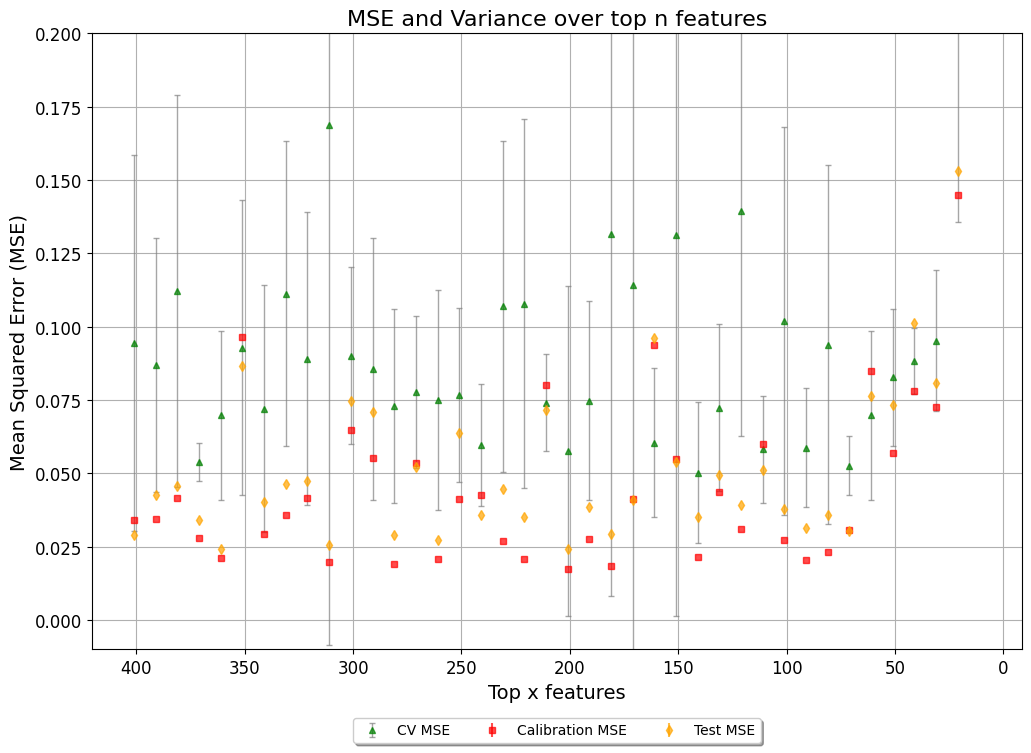

In [ ]:
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

#plt.errorbar(table.index[::-1], table['train mse'][::-1], yerr=table['train std'][::-1], fmt='o', markersize=5, capsize=2, label='Train MSE', color='blue', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['val mse'][::-1], yerr=table['val std'][::-1], fmt='^', markersize=5, capsize=2, label='CV MSE', color='green', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['calibration mse'][::-1], yerr=0, fmt='s', markersize=5, label='Calibration MSE', color='red', alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['test mse'][::-1], yerr=0, fmt='d', markersize=5, label='Test MSE', color='orange', alpha=0.7, linestyle='')

plt.xlabel('Top x features', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.title('MSE and Variance over top n features', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4)
plt.ylim(-0.01, 0.2)
plt.gca().invert_xaxis()  # Keep the x-axis inverted

plt.show()

In [ ]:
#write in memory...
df=pd.DataFrame(table)
dir_path='C:\\Users\\lucas\\Downloads'

os.makedirs(dir_path,exist_ok=True)
file_path=os.path.join(dir_path,'table_dataframe_NN_mrmr')
df.to_csv(file_path, index=False)

##### NN MI

In [6]:
def build_table_mi_nn(x_train,y_train,x_test,y_test,step,k_folds):
    #here i used the terms calibration and train somewhat interchangeably
    #the idea is that the complete train set without fold separation to be called calibration
    #the fold used to generate the model is train and the fold used to validade is validation...
    columns=['train mse','train std','val mse','val std','calibration mse','test mse','epochs']
    stored = pd.DataFrame(columns=columns)

    mi_scores=mutual_info_regression(x_train,y_train,n_neighbors=3)

    for features in tqdm(range(401, 390, -step)):
        
        important_idx=pd.Series(mi_scores).sort_values(ascending=False).head(features).index
    
        x_train_selected=x_train[important_idx.sort_values()]
        x_test_selected=x_test[important_idx.sort_values()]
        
        kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)
        
        train_mse_fold=[]
        val_mse_fold=[]
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train)):
        
            x_train_fold=x_train_selected.iloc[np.sort(train_idx)]
            y_train_fold=y_train.iloc[np.sort(train_idx)]
            x_val_fold=x_train_selected.iloc[np.sort(val_idx)]
            y_val_fold=y_train.iloc[np.sort(val_idx)]
            
            train_loader_fold=make_loader(X=x_train_fold,y=y_train_fold,batch=1000)
            val_loader_fold=make_loader(X=x_val_fold,y=y_val_fold,batch=1000)

            model,loss_fn,optimizer, _ =ini_model(input=features)#epochs defined inside function

            model,_ =train_early_stop_no_loss(TrainLoader=train_loader_fold,
                                           model=model,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           max_epochs=6000)
            
            train_loss_single_fold=evaluate(Loader=train_loader_fold, model=model, loss_fn=loss_fn)
            val_loss_single_fold=evaluate(Loader=val_loader_fold, model=model, loss_fn=loss_fn)
            
            train_mse_fold.append(train_loss_single_fold)
            val_mse_fold.append(val_loss_single_fold)
        
        train_loader=make_loader(X=x_train_selected,y=y_train,batch=1000)
        test_loader=make_loader(X=x_test_selected,y=y_test,batch=1000)

        model,loss_fn,optimizer, _ =ini_model(input=features) #definedinside function
        model, epoch=train_early_stop_no_loss(TrainLoader=train_loader,
                                           model=model,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           max_epochs=6000)
                
        train_loss=evaluate(Loader=train_loader, model=model, loss_fn=loss_fn)
        val_loss=evaluate(Loader=test_loader, model=model, loss_fn=loss_fn)
        
        #['avg train mse','std train mse,'avg val mse','std val mse','calibration mse','test mse']
        avg_loss_train_fold=np.mean(train_mse_fold)
        std_loss_train_fold=np.std(train_mse_fold)
        avg_loss_val_fold=np.mean(val_mse_fold)
        std_loss_val_fold=np.std(val_mse_fold)
        
        stored.loc[features] = [avg_loss_train_fold,
                                std_loss_train_fold,
                                avg_loss_val_fold,
                                std_loss_val_fold,
                                train_loss,
                                val_loss,
                                epoch]
            
    return stored

In [153]:
table=build_table_mi_nn(x_train=x_train,
                  y_train=y_train,
                  x_test=x_test,
                  y_test=y_test,
                  step=10,
                  k_folds=5)

100%|██████████| 2/2 [02:44<00:00, 82.06s/it] 


In [154]:
table

,train mse,train std,val mse,val std,calibration mse,test mse,epochs
401,0.032728,0.006174,0.075071,0.019777,0.044463,0.070941,2261.0
391,0.028609,0.004881,0.074102,0.025100,0.036222,0.038261,1012.0


##### PLS permutation importance functions

In [193]:
#function to evaluate permutation importance, evaluate on every fold, also stores learning curves...
def permutation_importance_pls(X_train,y_train,k_folds,latent_variables):
    
    if not isinstance(X_train, pd.DataFrame):
        try:
            X_train = pd.DataFrame(X_train)
        except ValueError:
            print("X cannot be converted to a pandas DataFrame.")
    
    if not isinstance(y_train, pd.Series):
        try:
            y_train = pd.Series(y_train)
        except ValueError:
            print("X cannot be converted to a pandas Series.")        
               
    kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)

    cross_importances=np.zeros((x_train.shape[1],kfold.n_splits))

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        
        x_train_fold=X_train.iloc[np.sort(train_idx)]
        y_train_fold=y_train.iloc[np.sort(train_idx)]
        x_val_fold=X_train.iloc[np.sort(val_idx)]
        y_val_fold=y_train.iloc[np.sort(val_idx)]
        
        pls=PLSRegression(n_components=latent_variables)
        pls.fit(x_train_fold,y_train_fold)
        
        results = permutation_importance(pls,
                                        x_val_fold,
                                        y_val_fold,
                                        n_repeats=30,
                                        random_state=42,
                                        n_jobs=4,
                                        scoring='neg_mean_squared_error')
        
        cross_importances[:,fold]=results.importances_mean
        
    return cross_importances

In [194]:
def build_table_pls(x_train,y_train,x_test,y_test,step,perm_imp_array,k_folds,latent_variables):
    #here i used the terms calibration and train somewhat interchangeably
    #the idea is that the complete train set without fold separation to be called calibration
    #the fold used to generate the model is train and the fold used to validade is validation...
    columns=['train mse','train std','val mse','val std','calibration mse','test mse']
    stored = pd.DataFrame(columns=columns)

    for features in np.arange(X.shape[1],1,-step):
        
        important_idx=perm_imp_get_topn_indexes(perm_imp_output=perm_imp_array,
                                                top_n=features)
    
        x_train_reduced=x_train[important_idx.sort_values()]
        x_test_reduced=x_test[important_idx.sort_values()]
        
        kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)
        
        train_mse_fold=[]
        val_mse_fold=[]
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train_reduced)):
        
            x_train_fold=x_train_reduced.iloc[np.sort(train_idx)]
            y_train_fold=y_train.iloc[np.sort(train_idx)]
            x_val_fold=x_train_reduced.iloc[np.sort(val_idx)]
            y_val_fold=y_train.iloc[np.sort(val_idx)]
            
            pls=PLSRegression(n_components=latent_variables)
            pls.fit(x_train_fold,y_train_fold)
            
            train_loss_single_fold=mean_squared_error(y_train_fold,pls.predict(x_train_fold))
            val_loss_single_fold=mean_squared_error(y_val_fold,pls.predict(x_val_fold))
            
            train_mse_fold.append(train_loss_single_fold)
            val_mse_fold.append(val_loss_single_fold)
        

        pls=PLSRegression(n_components=latent_variables)
        pls.fit(x_train_reduced,y_train)
        
        train_loss=mean_squared_error(y_train,pls.predict(x_train_reduced))
        test_loss=mean_squared_error(y_test,pls.predict(x_test_reduced))
    
        #['avg train mse','std train mse,'avg val mse','std val mse','calibration mse','test mse']
        avg_loss_train_fold=np.mean(train_mse_fold)
        std_loss_train_fold=np.std(train_mse_fold)
        avg_loss_val_fold=np.mean(val_mse_fold)
        std_loss_val_fold=np.std(val_mse_fold)
        
        stored.loc[features] = [avg_loss_train_fold,
                                std_loss_train_fold,
                                avg_loss_val_fold,
                                std_loss_val_fold,
                                train_loss,
                                test_loss]
            
    return stored

##### PLS permutation importance evaluation

In [36]:
components_used=[]
train_list=[]
test_list=[]
cv_list=[]
for i in np.arange(1,51,1):
    
    pls=PLSRegression(n_components=i)
    pls.fit(x_train,y_train)
    pred_train=pls.predict(x_train)
    pred_test=pls.predict(x_test)
    train_mse=mean_squared_error(y_train,pred_train)
    test_mse=mean_squared_error(y_test,pred_test)
    
    cv_scores = cross_val_score(pls, x_train, y_train, scoring='neg_mean_squared_error')
    # Since scores are negative, take the absolute value to get the mean squared error
    cv_mse = -cv_scores

    cv_list.append(cv_mse.mean())
    train_list.append(train_mse)
    test_list.append(test_mse)
    components_used.append(i)

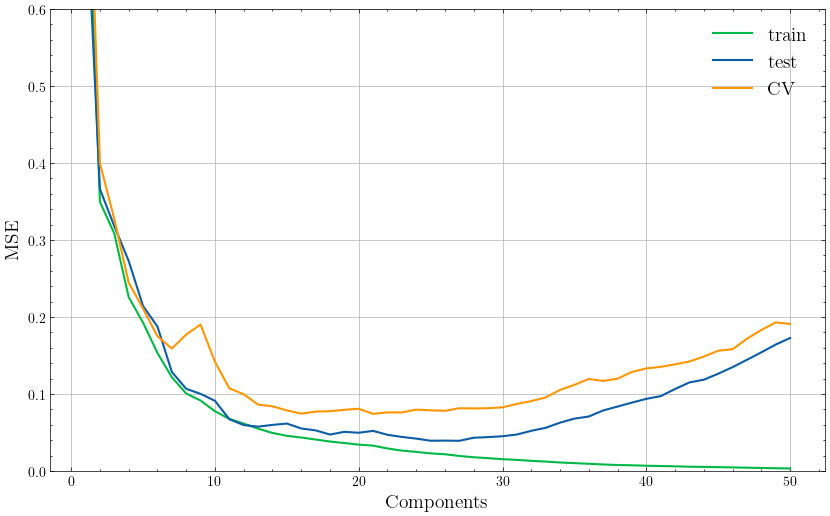

In [53]:

plt.style.use('science')

# Creating the figure with a specified size
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the data
ax.plot(components_used, train_list, label='train', color='C1', linewidth=1.5)
ax.plot(components_used, test_list, label='test', color='C0', linewidth=1.5)
ax.plot(components_used, cv_list, label='CV', color='C2', linewidth=1.5)

# Adding legend
ax.legend(fontsize=14)

# Setting the title and axis labels
#ax.set_title('PLSR Error Over Components')
ax.set_xlabel('Components',fontsize=14)
ax.set_ylabel('MSE',fontsize=14)

# Setting y-axis limits
ax.set_ylim(0, 0.6)

# Adding grid lines for better readability
ax.grid(True)

# Ensuring the ticks are more visible


# Saving the figure in both vector and high-resolution raster formats
#fig.savefig('pls_error_over_components.pdf', format='pdf', bbox_inches='tight')
#fig.savefig('pls_error_over_components.svg', format='svg', bbox_inches='tight')
fig.savefig('C:\\Users\\lucas\\Downloads\\pls_error_over_components.pdf', format='pdf', bbox_inches='tight')
#fig.savefig('C:\\Users\\lucas\\Downloads\\pls_error_over_components.png', format='png', dpi=300, bbox_inches='tight')
# Displaying the plot
plt.show()

In [198]:
importances_pls=permutation_importance_pls(X_train=x_train,
                                           y_train=y_train,
                                           k_folds=5,
                                           latent_variables=9)

KeyboardInterrupt: 

In [ ]:

importance_rank=pd.DataFrame(importances_pls).rank(ascending=False)
importance_rank_named=importance_rank.rename(columns={0:'fold1',1:'fold2',2:'fold3',3:'fold4',4:'fold5'})
#importance_overall_rank=importance_rank_named.mean(axis=1)
importance_overall_rank_pls=importance_rank_named.median(axis=1) #using median is more robust to outliers 

In [ ]:
check_intersections(importance_rank_named,200)

,fold1,fold2,fold3,fold4,fold5
fold1,1.000,0.685,0.710,0.730,0.685
fold2,0.685,1.000,0.585,0.690,0.610
fold3,0.710,0.585,1.000,0.750,0.865
fold4,0.730,0.690,0.750,1.000,0.785
fold5,0.685,0.610,0.865,0.785,1.000


In [212]:
table = build_table_pls(x_train=x_train,
                        y_train=y_train,
                       x_test=x_test,
                       y_test=y_test,
                       step=100,
                       perm_imp_array=importance_overall_rank_pls,
                       k_folds=5,
                       latent_variables=9)

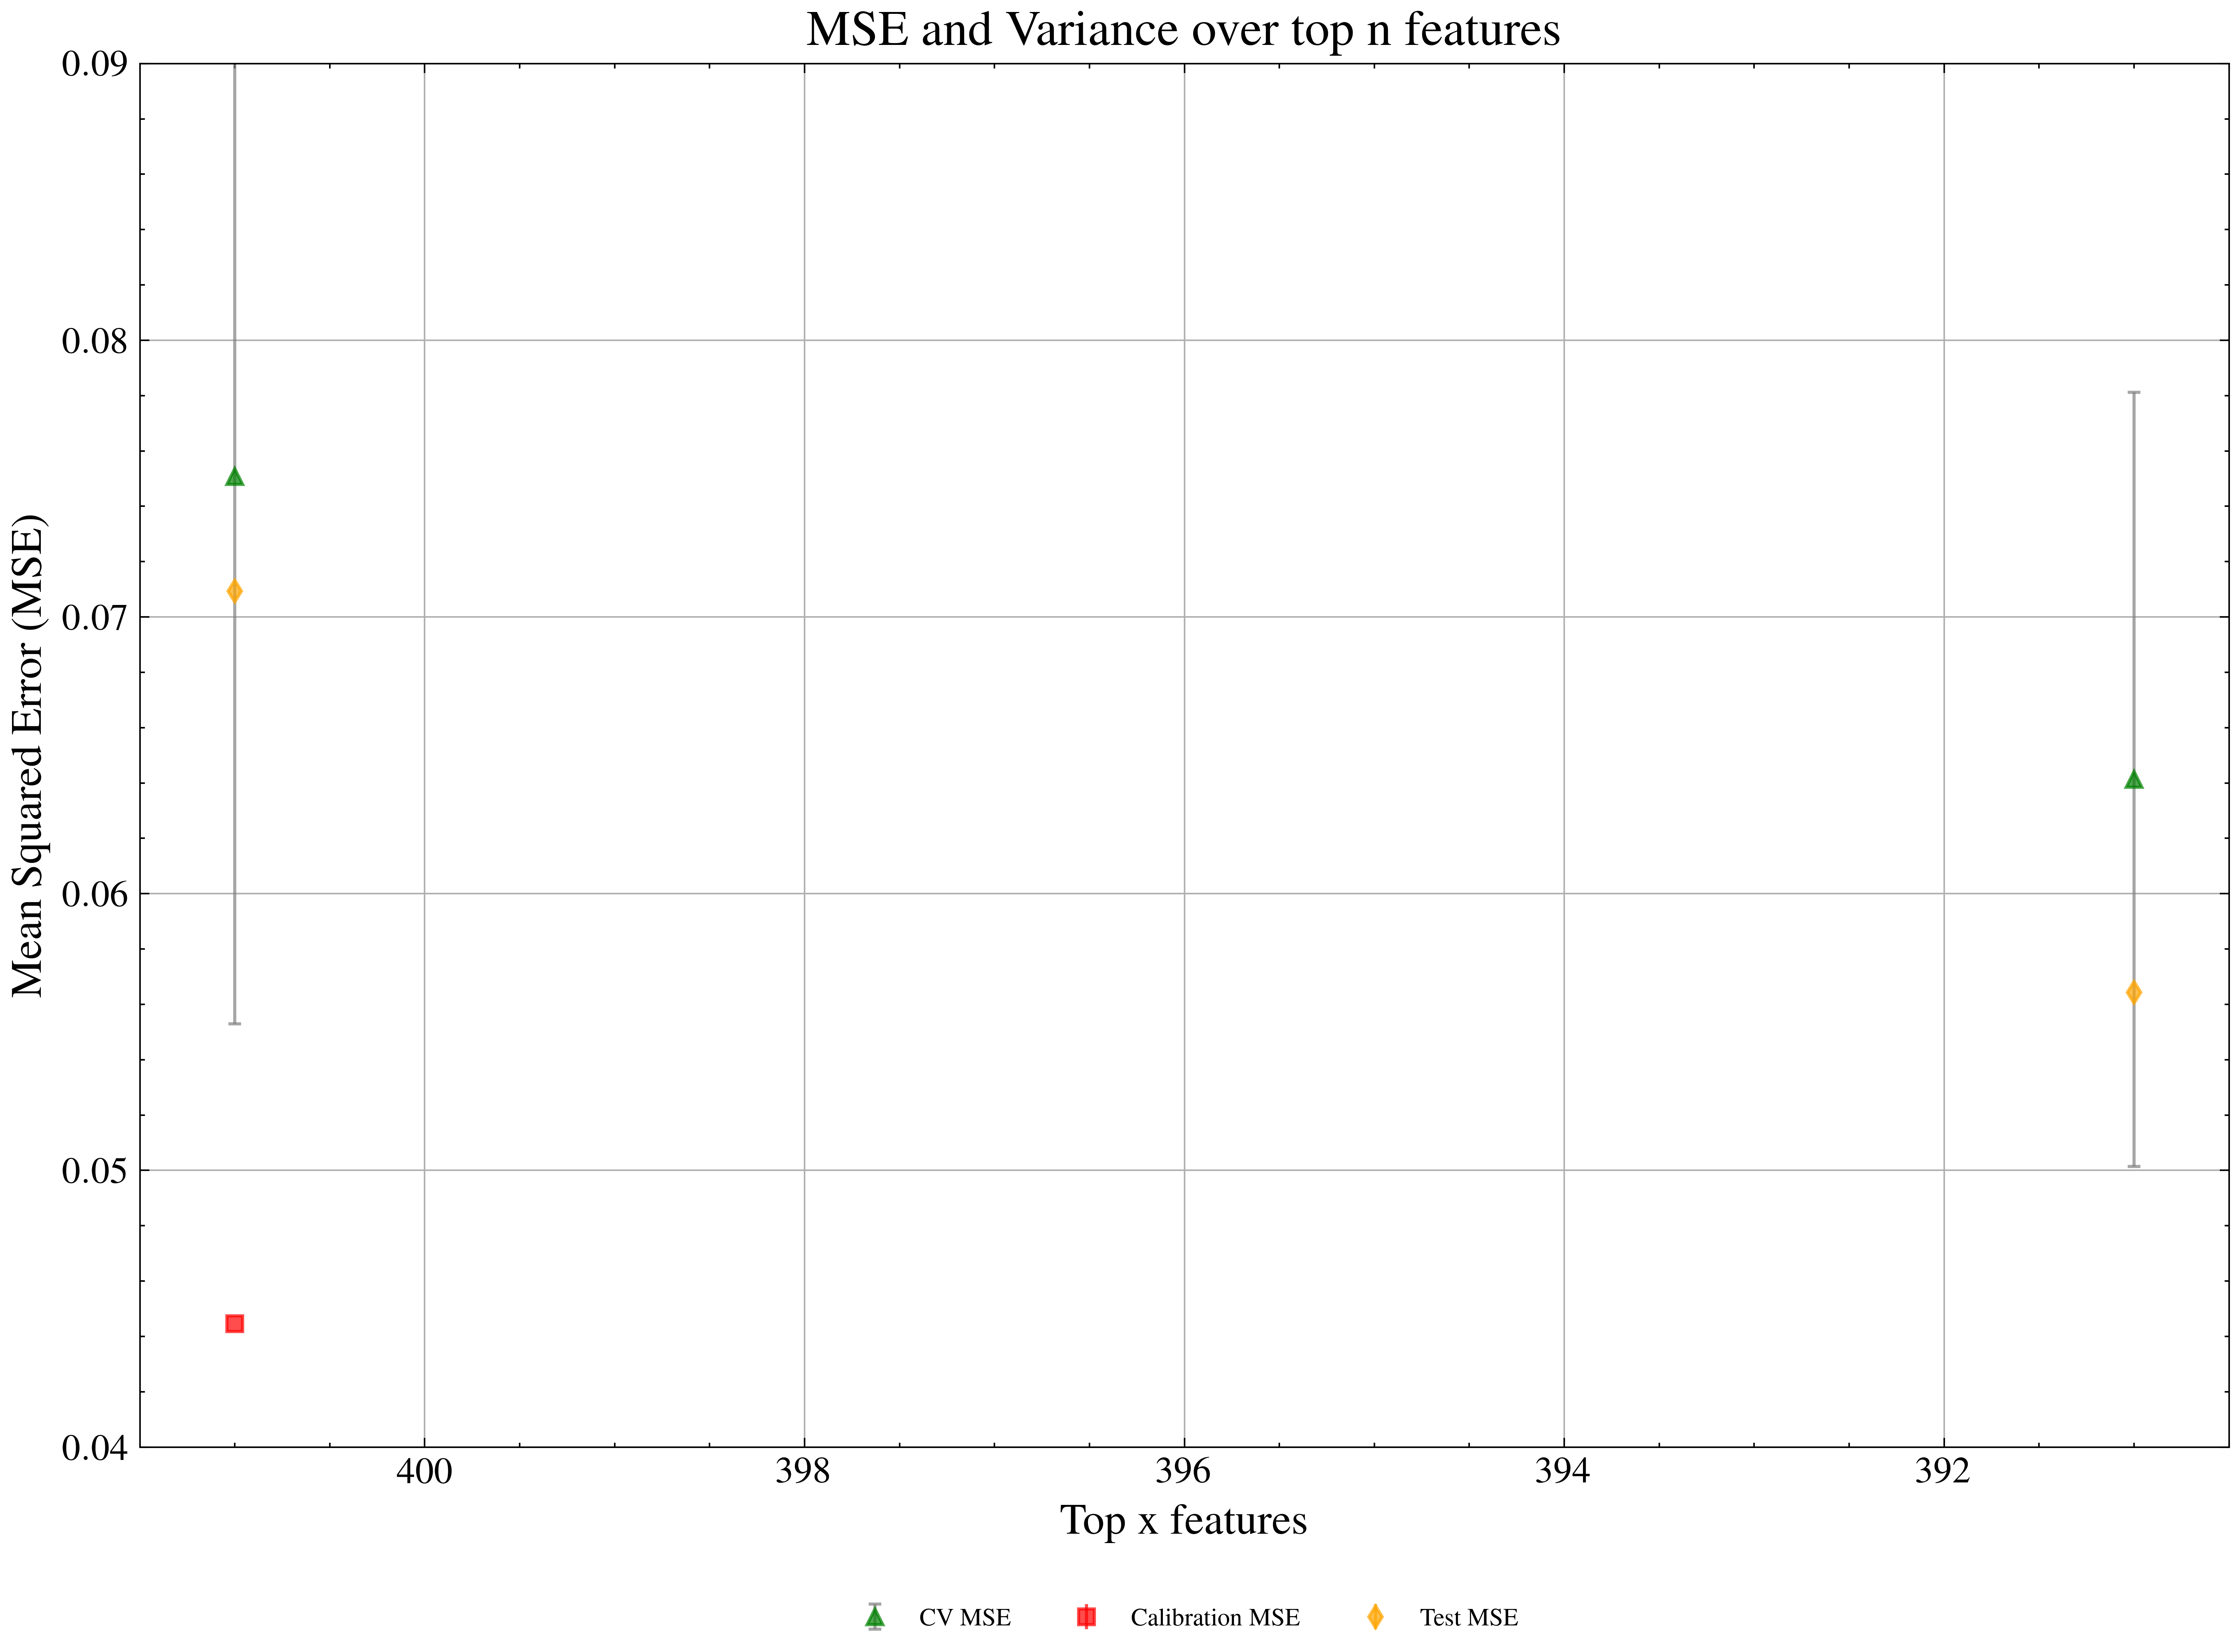

In [160]:
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

#plt.errorbar(table.index[::-1], table['train mse'][::-1], yerr=table['train std'][::-1], fmt='o', markersize=5, capsize=2, label='Train MSE', color='blue', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['val mse'][::-1], yerr=table['val std'][::-1], fmt='^', markersize=5, capsize=2, label='CV MSE', color='green', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['calibration mse'][::-1], yerr=0, fmt='s', markersize=5, label='Calibration MSE', color='red', alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['test mse'][::-1], yerr=0, fmt='d', markersize=5, label='Test MSE', color='orange', alpha=0.7, linestyle='')

plt.xlabel('Top x features', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.title('MSE and Variance over top n features', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4)
plt.ylim(0.04,0.09)
plt.gca().invert_xaxis()  # Keep the x-axis inverted

plt.show()

##### PLS MI

In [237]:
def build_table_mutual_info_PLS(x_train,y_train,x_test,y_test,step,k_folds,latent_variables):
    #here i used the terms calibration and train somewhat interchangeably
    #the idea is that the complete train set without fold separation to be called calibration
    #the fold used to generate the model is train and the fold used to validade is validation...
    columns=['train mse','train std','val mse','val std','calibration mse','test mse']
    stored = pd.DataFrame(columns=columns)

    mi_scores=mutual_info_regression(x_train,y_train,n_neighbors=3)

    for features in np.arange(X.shape[1],50,-step):
        
        important_idx=pd.Series(mi_scores).sort_values(ascending=False).head(features).index
    
        x_train=x_train[important_idx.sort_values()]
        x_test=x_test[important_idx.sort_values()]
        
        kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)
        
        train_mse_fold=[]
        val_mse_fold=[]
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train)):
        
            x_train_fold=x_train.iloc[np.sort(train_idx)]
            y_train_fold=y_train.iloc[np.sort(train_idx)]
            x_val_fold=x_train.iloc[np.sort(val_idx)]
            y_val_fold=y_train.iloc[np.sort(val_idx)]
            
            pls=PLSRegression(n_components=latent_variables)
            pls.fit(x_train_fold,y_train_fold)
            
            train_loss_single_fold=mean_squared_error(y_train_fold,pls.predict(x_train_fold))
            val_loss_single_fold=mean_squared_error(y_val_fold,pls.predict(x_val_fold))
            
            train_mse_fold.append(train_loss_single_fold)
            val_mse_fold.append(val_loss_single_fold)
        

        pls=PLSRegression(n_components=latent_variables)
        pls.fit(x_train,y_train)
        
        train_loss=mean_squared_error(y_train,pls.predict(x_train))
        test_loss=mean_squared_error(y_test,pls.predict(x_test))
    
        #['avg train mse','std train mse,'avg val mse','std val mse','calibration mse','test mse']
        avg_loss_train_fold=np.mean(train_mse_fold)
        std_loss_train_fold=np.std(train_mse_fold)
        avg_loss_val_fold=np.mean(val_mse_fold)
        std_loss_val_fold=np.std(val_mse_fold)
        
        stored.loc[features] = [avg_loss_train_fold,
                                std_loss_train_fold,
                                avg_loss_val_fold,
                                std_loss_val_fold,
                                train_loss,
                                test_loss]
            
    return stored

In [244]:
table=build_table_mutual_info_PLS(x_train=x_train,
                                  y_train=y_train,
                                  x_test=x_test,
                                  y_test=y_test,
                                  step=50,
                                  k_folds=5,
                                  latent_variables=9)

In [245]:
table

,train mse,train std,val mse,val std,calibration mse,test mse
1845,0.305322,0.014192,0.361694,0.064923,0.311743,0.285829
1795,0.301479,0.012801,0.363392,0.063158,0.308515,0.285538
1745,0.288165,0.010147,0.353660,0.065215,0.296323,0.302442
1695,0.291216,0.009979,0.358473,0.068081,0.298989,0.325131
1645,0.293442,0.013853,0.359387,0.073117,0.302458,0.336927
1595,0.296472,0.015095,0.362885,0.077066,0.305078,0.339936
1545,0.298422,0.015565,0.363523,0.078615,0.306708,0.341476
1495,0.298490,0.015739,0.362897,0.079016,0.306624,0.342492
1445,0.295891,0.015279,0.361369,0.077190,0.303903,0.341294
1395,0.291604,0.014491,0.359040,0.072282,0.299449,0.341746


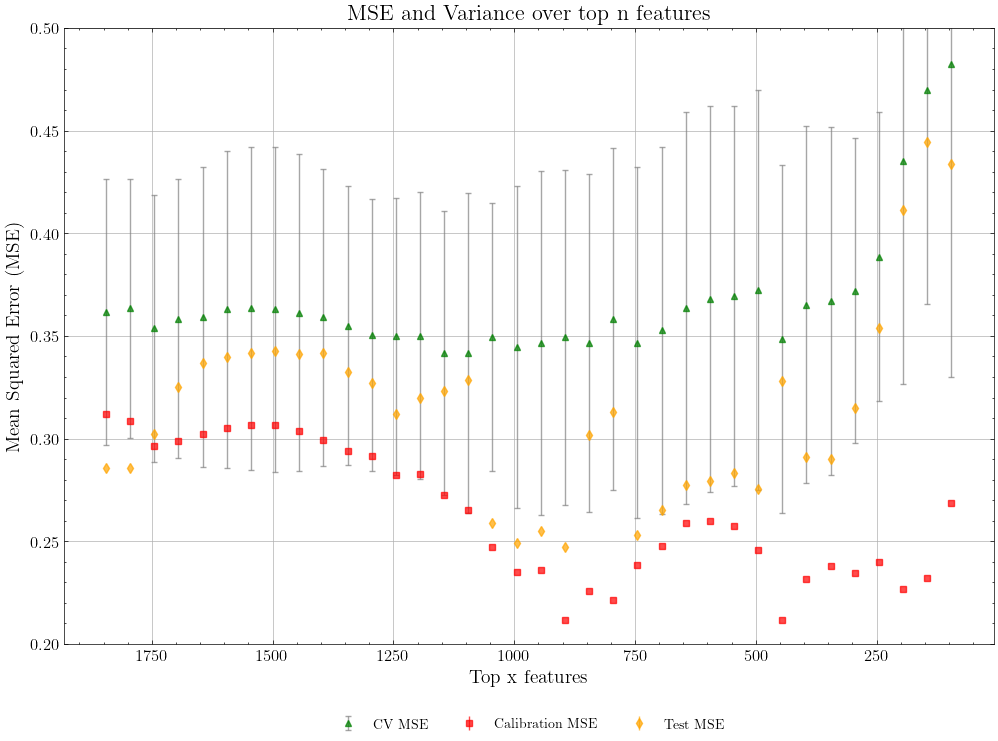

In [246]:
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

#plt.errorbar(table.index[::-1], table['train mse'][::-1], yerr=table['train std'][::-1], fmt='o', markersize=5, capsize=2, label='Train MSE', color='blue', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['val mse'][::-1], yerr=table['val std'][::-1], fmt='^', markersize=5, capsize=2, label='CV MSE', color='green', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['calibration mse'][::-1], yerr=0, fmt='s', markersize=5, label='Calibration MSE', color='red', alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['test mse'][::-1], yerr=0, fmt='d', markersize=5, label='Test MSE', color='orange', alpha=0.7, linestyle='')

plt.xlabel('Top x features', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.title('MSE and Variance over top n features', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4)
plt.ylim(0.2,0.5)
plt.gca().invert_xaxis()  # Keep the x-axis inverted

plt.show()

##### PLS mRMR

In [116]:
def build_table_pls_mrmr(x_train,y_train,x_test,y_test,step,k_folds,latent_variables):
    #here i used the terms calibration and train somewhat interchangeably
    #the idea is that the complete train set without fold separation to be called calibration
    #the fold used to generate the model is train and the fold used to validade is validation...
    columns=['train mse','train std','val mse','val std','calibration mse','test mse']
    stored = pd.DataFrame(columns=columns)

    selected_features=mrmr_regression(X=x_train,
                                      y=y_train,
                                      K=401)
    
    for features in np.arange(401,399,-step):
        
        important_idx=selected_features[0:features]
    
        x_train=x_train[important_idx]
        x_test=x_test[important_idx]
        
        kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)
        
        train_mse_fold=[]
        val_mse_fold=[]
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train)):
        
            x_train_fold=x_train.iloc[np.sort(train_idx)]
            y_train_fold=y_train.iloc[np.sort(train_idx)]
            x_val_fold=x_train.iloc[np.sort(val_idx)]
            y_val_fold=y_train.iloc[np.sort(val_idx)]
            
            pls=PLSRegression(n_components=latent_variables)
            pls.fit(x_train_fold,y_train_fold)
            
            train_loss_single_fold=mean_squared_error(y_train_fold,pls.predict(x_train_fold))
            val_loss_single_fold=mean_squared_error(y_val_fold,pls.predict(x_val_fold))
            
            train_mse_fold.append(train_loss_single_fold)
            val_mse_fold.append(val_loss_single_fold)
        

        pls=PLSRegression(n_components=latent_variables)
        pls.fit(x_train,y_train)
        
        train_loss=mean_squared_error(y_train,pls.predict(x_train))
        test_loss=mean_squared_error(y_test,pls.predict(x_test))
    
        #['avg train mse','std train mse,'avg val mse','std val mse','calibration mse','test mse']
        avg_loss_train_fold=np.mean(train_mse_fold)
        std_loss_train_fold=np.std(train_mse_fold)
        avg_loss_val_fold=np.mean(val_mse_fold)
        std_loss_val_fold=np.std(val_mse_fold)
        
        stored.loc[features] = [avg_loss_train_fold,
                                std_loss_train_fold,
                                avg_loss_val_fold,
                                std_loss_val_fold,
                                train_loss,
                                test_loss]
            
    return stored

In [21]:
#this code yielded me exactly the same values the library returned.
'''
import pandas as pd
from sklearn.feature_selection import f_regression
def custom_mrmr(X,y,K):
    # inputs:
    #    X: pandas.DataFrame, features
    #    y: pandas.Series, target variable
    #    K: number of features to select

    # compute F-statistics and correlations
    F = pd.Series(f_regression(X, y)[0], index = X.columns)
    corr = X.corr().abs().clip(.00001) # minimum value of correlation set to .00001 (to avoid division by zero)

    # initialize list of selected features and list of excluded features
    selected = []
    not_selected = list(X.columns)

    # repeat K times: 
    # compute FCQ score for all the features that are currently excluded,
    # then find the best one, add it to selected, and remove it from not_selected
    for i in range(K):
        
        # compute FCQ score for all the (currently) excluded features (this is Formula 2)
        score = F.loc[not_selected] / corr.loc[not_selected, selected].mean(axis = 1).fillna(.00001)
        
        # find best feature, add it to selected and remove it from not_selected
        best = score.index[score.argmax()]
        selected.append(best)
        not_selected.remove(best)
    return selected
'''

'\nimport pandas as pd\nfrom sklearn.feature_selection import f_regression\ndef custom_mrmr(X,y,K):\n    # inputs:\n    #    X: pandas.DataFrame, features\n    #    y: pandas.Series, target variable\n    #    K: number of features to select\n\n    # compute F-statistics and correlations\n    F = pd.Series(f_regression(X, y)[0], index = X.columns)\n    corr = X.corr().abs().clip(.00001) # minimum value of correlation set to .00001 (to avoid division by zero)\n\n    # initialize list of selected features and list of excluded features\n    selected = []\n    not_selected = list(X.columns)\n\n    # repeat K times: \n    # compute FCQ score for all the features that are currently excluded,\n    # then find the best one, add it to selected, and remove it from not_selected\n    for i in range(K):\n        \n        # compute FCQ score for all the (currently) excluded features (this is Formula 2)\n        score = F.loc[not_selected] / corr.loc[not_selected, selected].mean(axis = 1).fillna(.000

In [117]:
table = build_table_pls_mrmr(x_train=x_train,
                             y_train=y_train,
                             x_test=x_test,
                             y_test=y_test,  
                             step=1,
                             k_folds=5,
                             latent_variables=1)

100%|██████████| 401/401 [00:12<00:00, 31.42it/s]


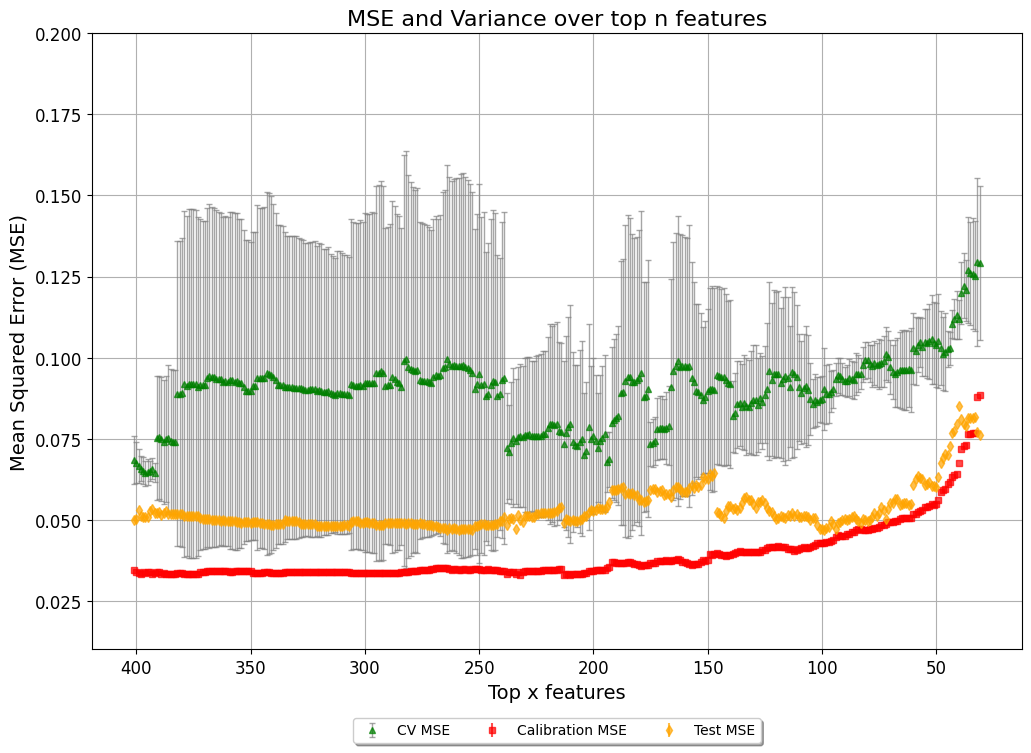

In [ ]:
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

#plt.errorbar(table.index[::-1], table['train mse'][::-1], yerr=table['train std'][::-1], fmt='o', markersize=5, capsize=2, label='Train MSE', color='blue', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['val mse'][::-1], yerr=table['val std'][::-1], fmt='^', markersize=5, capsize=2, label='CV MSE', color='green', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['calibration mse'][::-1], yerr=0, fmt='s', markersize=5, label='Calibration MSE', color='red', alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['test mse'][::-1], yerr=0, fmt='d', markersize=5, label='Test MSE', color='orange', alpha=0.7, linestyle='')

plt.xlabel('Top x features', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.title('MSE and Variance over top n features', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4)
plt.ylim(0.01,0.2)
plt.gca().invert_xaxis()  # Keep the x-axis inverted

plt.show()

In [ ]:
def build_table_mutual_info_pls(x_train,y_train,x_test,y_test,step,k_folds,latent_variables):
    #here i used the terms calibration and train somewhat interchangeably
    #the idea is that the complete train set without fold separation to be called calibration
    #the fold used to generate the model is train and the fold used to validade is validation...
    columns=['train mse','train std','val mse','val std','calibration mse','test mse']
    stored = pd.DataFrame(columns=columns)

    mi_scores=mutual_info_regression(x_train,y_train,n_neighbors=3)

    for features in np.arange(401,150,-step):
        
        important_idx=pd.Series(mi_scores).sort_values(ascending=False).head(features).index
    
        x_train=x_train[important_idx.sort_values()]
        x_test=x_test[important_idx.sort_values()]
        
        kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)
        
        train_mse_fold=[]
        val_mse_fold=[]
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train)):
        
            x_train_fold=x_train.iloc[np.sort(train_idx)]
            y_train_fold=y_train.iloc[np.sort(train_idx)]
            x_val_fold=x_train.iloc[np.sort(val_idx)]
            y_val_fold=y_train.iloc[np.sort(val_idx)]
            
            pls=PLSRegression(n_components=latent_variables)
            pls.fit(x_train_fold,y_train_fold)
            
            train_loss_single_fold=mean_squared_error(y_train_fold,pls.predict(x_train_fold))
            val_loss_single_fold=mean_squared_error(y_val_fold,pls.predict(x_val_fold))
            
            train_mse_fold.append(train_loss_single_fold)
            val_mse_fold.append(val_loss_single_fold)
        

        pls=PLSRegression(n_components=latent_variables)
        pls.fit(x_train,y_train)
        
        train_loss=mean_squared_error(y_train,pls.predict(x_train))
        test_loss=mean_squared_error(y_test,pls.predict(x_test))
    
        #['avg train mse','std train mse,'avg val mse','std val mse','calibration mse','test mse']
        avg_loss_train_fold=np.mean(train_mse_fold)
        std_loss_train_fold=np.std(train_mse_fold)
        avg_loss_val_fold=np.mean(val_mse_fold)
        std_loss_val_fold=np.std(val_mse_fold)
        
        stored.loc[features] = [avg_loss_train_fold,
                                std_loss_train_fold,
                                avg_loss_val_fold,
                                std_loss_val_fold,
                                train_loss,
                                test_loss]
            
    return stored

In [ ]:
table=build_table_mutual_info_pls(x_train=x_train,
                                  y_train=y_train,
                                  x_test=x_test,
                                  y_test=y_test,
                                  step=1,
                                  k_folds=5,
                                  latent_variables=20)

In [ ]:
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

#plt.errorbar(table.index[::-1], table['train mse'][::-1], yerr=table['train std'][::-1], fmt='o', markersize=5, capsize=2, label='Train MSE', color='blue', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['val mse'][::-1], yerr=table['val std'][::-1], fmt='^', markersize=5, capsize=2, label='CV MSE', color='green', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['calibration mse'][::-1], yerr=0, fmt='s', markersize=5, label='Calibration MSE', color='red', alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['test mse'][::-1], yerr=0, fmt='d', markersize=5, label='Test MSE', color='orange', alpha=0.7, linestyle='')

plt.xlabel('Top x features', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.title('MSE and Variance over top n features', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4)
plt.ylim(0.01,0.2)
plt.gca().invert_xaxis()  # Keep the x-axis inverted

plt.show()

##### PLS mrmr best n_components for top_n variables

In [86]:
def pls_mrmr_find_best(x_train, y_train, x_test, y_test, step, k_folds):
    columns = ['top_n', 'CV', 'train', 'test mse', 'n_components']
    stored = pd.DataFrame(columns=columns)
    
    selected_features=mrmr_regression(X=x_train,
                                      y=y_train,
                                      K=401)
    
    for features in tqdm(np.arange(150, 1, -step)):
        
        important_idx=selected_features[0:features]
        
        # Selecting the important features and then sorting the columns by their names to ensure consistent order
        x_train_important = x_train.iloc[:, important_idx].sort_index(axis=1)
        x_test_important = x_test.iloc[:, important_idx].sort_index(axis=1)
        
        kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
        
        best_CV = np.inf
        best_n_components = 0
        
        for latent_variables in range(1, features+1):
            val_mse_fold = []
            
            for _, (train_idx, val_idx) in enumerate(kfold.split(x_train_important)):
                # Sorting the indices to ensure consistent ordering
                train_idx_sorted = np.sort(train_idx)
                val_idx_sorted = np.sort(val_idx)
                
                x_train_fold = x_train_important.iloc[train_idx_sorted]
                y_train_fold = y_train.iloc[train_idx_sorted]
                x_val_fold = x_train_important.iloc[val_idx_sorted]
                y_val_fold = y_train.iloc[val_idx_sorted]
                
                pls = PLSRegression(n_components=latent_variables)
                pls.fit(x_train_fold, y_train_fold)
                
                val_loss_single_fold = mean_squared_error(y_val_fold, pls.predict(x_val_fold))
                val_mse_fold.append(val_loss_single_fold)
            
            avg_loss_val_fold = np.mean(val_mse_fold)
            
            if avg_loss_val_fold < best_CV:  # Update best
                best_CV = avg_loss_val_fold
                best_n_components = latent_variables
                
        pls = PLSRegression(n_components=best_n_components)
        pls.fit(x_train_important, y_train)
        
        train_loss = mean_squared_error(y_train, pls.predict(x_train_important))
        test_loss = mean_squared_error(y_test, pls.predict(x_test_important))
        
        stored.loc[features] = [features, best_CV, train_loss, test_loss, best_n_components]
        
    return stored

In [87]:
table=pls_mrmr_find_best(x_train=x_train,
                    y_train=y_train,
                    x_test=x_test,
                    y_test=y_test,
                    step=1,
                    k_folds=5)

100%|██████████| 149/149 [22:52<00:00,  9.21s/it] 


In [88]:
table

,top_n,CV,train,test mse,n_components
150,150.0,0.079780,0.060489,0.055561,12.0
149,149.0,0.081128,0.060655,0.057383,12.0
148,148.0,0.081158,0.060654,0.057396,12.0
147,147.0,0.081242,0.060772,0.057636,12.0
146,146.0,0.080186,0.056424,0.054860,13.0
...,...,...,...,...,...
6,6.0,0.361459,0.347412,0.331992,6.0
5,5.0,0.453976,0.434598,0.411558,5.0
4,4.0,0.497183,0.477056,0.456484,4.0
3,3.0,0.510222,0.495754,0.469688,2.0


In [89]:
#write in memory...
df=pd.DataFrame(table)
dir_path='C:\\Users\\lucas\\Downloads'

os.makedirs(dir_path,exist_ok=True)
file_path=os.path.join(dir_path,'table_top_n__best_n_components_pls_mrmr_150_to_1.csv')
df.to_csv(file_path, index=False)

In [22]:
df1=pd.read_csv("C:\\Users\\lucas\\Downloads\\table_top_n__best_n_components_pls_mrmr.csv")
df2=pd.read_csv("C:\\Users\\lucas\\Downloads\\table_top_n__best_n_components_pls_mrmr_150_to_1.csv")
table=pd.concat([df1,df2])

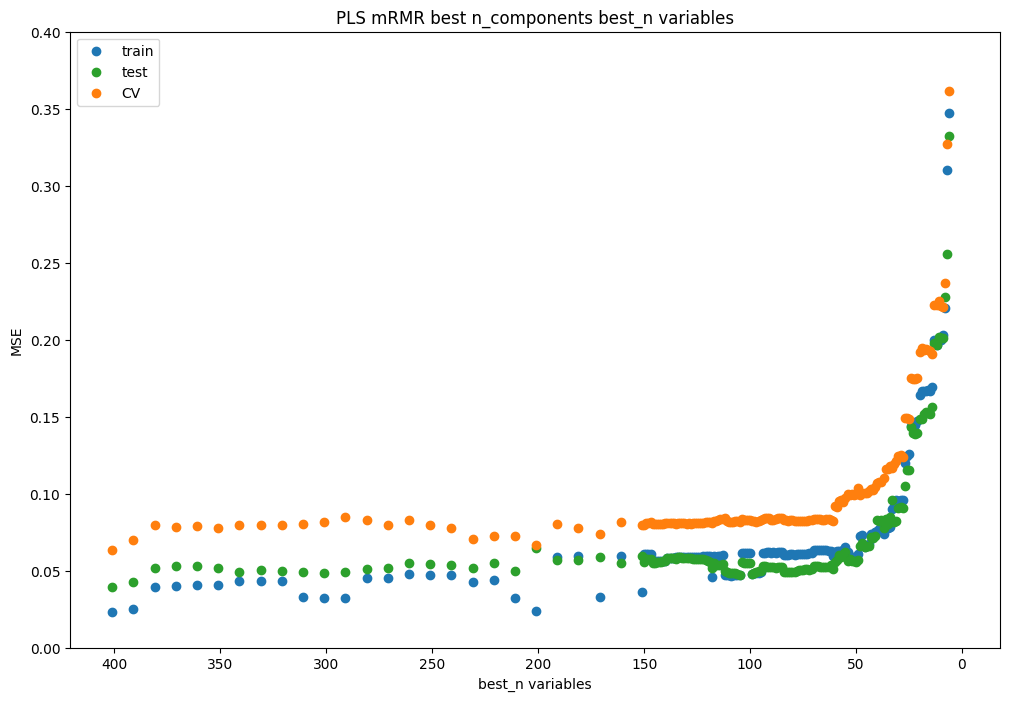

In [96]:
plt.figure(figsize=(12,8))

plt.scatter(df2['top_n'], df2['train'], color='C0', marker='o', label='train')
plt.scatter(df1['top_n'], df1['train'], color='C0', marker='o')

plt.scatter(df2['top_n'], df2['test mse'], color='C2', marker='o', label='test')
plt.scatter(df1['top_n'], df1['test mse'], color='C2', marker='o')

plt.scatter(df2['top_n'], df2['CV'], color='C1', marker='o', label='CV')
plt.scatter(df1['top_n'], df1['CV'], color='C1', marker='o')

plt.ylim(0,0.4)
plt.gca().invert_xaxis()

plt.ylabel('MSE')
plt.xlabel('best_n variables')
plt.title('PLS mRMR best n_components best_n variables')

plt.legend()

Text(0.5, 1.0, 'PLS mRMR best n_components best_n variables')

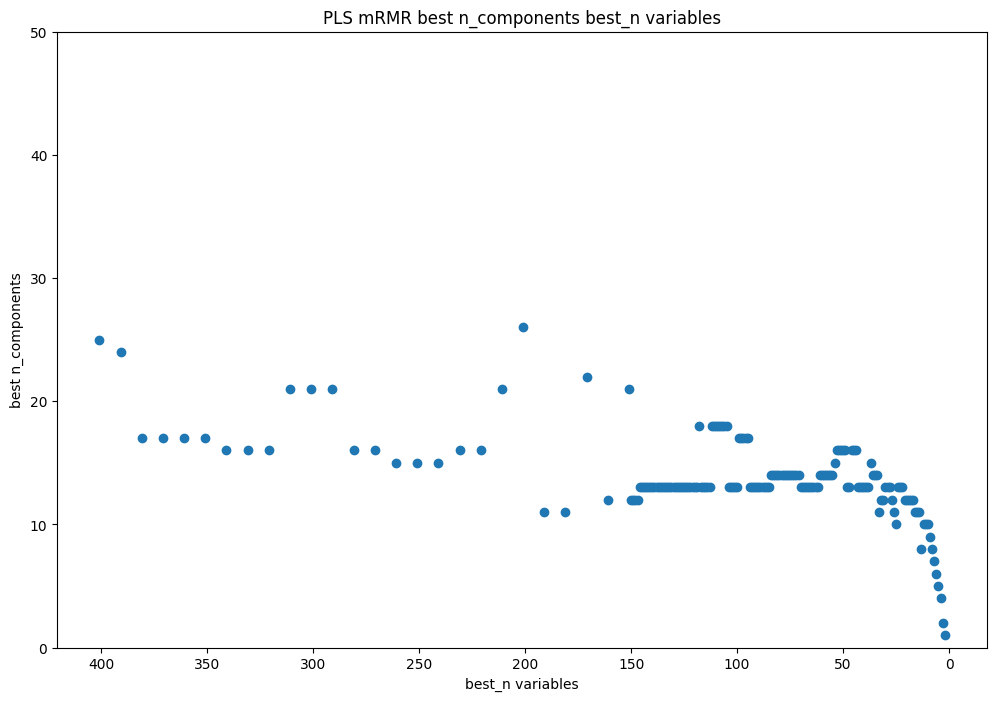

In [99]:
plt.figure(figsize=(12,8))

plt.scatter(df2['top_n'], df2['n_components'], color='C0', marker='o')
plt.scatter(df1['top_n'], df1['n_components'], color='C0', marker='o')

plt.ylim(0,50)
plt.gca().invert_xaxis()

plt.ylabel('best n_components')
plt.xlabel('best_n variables')
plt.title('PLS mRMR best n_components best_n variables')

##### Comparison of most important features

In [88]:
def show_imp(X,important,top_n):
    features=np.arange(X.shape[1])
    features=pd.Series(features).sort_values()
    
    best_n=perm_imp_get_topn_indexes(important,top_n)
    true_false=features.isin(best_n)
    return true_false

In [89]:
#NN perm importance
importances,train_loss_list,val_loss_list=permutation_importance_loss_nn(X_train=x_train,
                                                                      y_train=y_train,
                                                                      k_folds=5)
importance_rank=pd.DataFrame(importances).rank(ascending=False)
importance_rank_named=importance_rank.rename(columns={0:'fold1',1:'fold2',2:'fold3',3:'fold4',4:'fold5'})
#importance_overall_rank=importance_rank_named.mean(axis=1)
importance_overall_rank_nn=importance_rank_named.median(axis=1) #using median is more robust to outliers 

In [93]:
#pls perm importance
importances_pls=permutation_importance_pls(X_train=x_train,
                                           y_train=y_train,
                                           k_folds=5,
                                           latent_variables=15)
importance_rank=pd.DataFrame(importances_pls).rank(ascending=False)
importance_rank_named=importance_rank.rename(columns={0:'fold1',1:'fold2',2:'fold3',3:'fold4',4:'fold5'})
#importance_overall_rank=importance_rank_named.mean(axis=1)
importance_overall_rank_pls=importance_rank_named.median(axis=1) #using median is more robust to outliers 

In [94]:
#mrmr
selected_features_mrmr=mrmr_regression(X=x_train,
                                  y=y_train,
                                  K=401)

mrmr_rank=pd.DataFrame(selected_features_mrmr).sort_values(by=0)
mrmr_rank=pd.Series(mrmr_rank.index.ravel())

100%|██████████| 401/401 [00:13<00:00, 29.90it/s]


In [95]:
#mutual info
mi_scores=mutual_info_regression(x_train,y_train,n_neighbors=3)

mi_rank_df=pd.DataFrame(mi_scores).rank(ascending=False)
mi_rank=pd.Series(mi_rank_df.values.ravel())

In [96]:
svr_sequential_rank_df=pd.DataFrame(flat_list).sort_values(by=0)
svr_sequential_rank=pd.Series(svr_sequential_rank_df.index.ravel())

In [97]:
importances_svm=permutation_importance_svm(X_train=x_train,
                                           y_train=y_train,
                                           k_folds=5)
importance_rank=pd.DataFrame(importances_svm).rank(ascending=False)
importance_rank_named=importance_rank.rename(columns={0:'fold1',1:'fold2',2:'fold3',3:'fold4',4:'fold5'})
#importance_overall_rank=importance_rank_named.mean(axis=1)
importance_overall_rank_svm=importance_rank_named.median(axis=1) #using median is more robust to outliers 

In [118]:
test_svm_sequential=show_imp(X,svr_sequential_rank,200)
test_svm_perm_imp=show_imp(X,importance_overall_rank_svm,200)
test_mi=show_imp(X,mi_rank,200)
test_mrmr=show_imp(X,mrmr_rank,200)

pls=show_imp(X,importance_overall_rank_pls,200)
svm=show_imp(X,importance_overall_rank_svm,200)
nn=show_imp(X,importance_overall_rank_nn,200)

In [119]:
array=np.array([pls,svm,nn])
array=array.astype(int)
data=pd.DataFrame(array.T,columns=['pls','svm','nn'])

In [107]:
array=np.array([test_svm_sequential,test_svm_perm_imp,test_mi,test_mrmr])
array=array.astype(int)
data=pd.DataFrame(array.T,columns=['sequential','permutation','MI','mrmr'])

In [111]:
#F test
f_score,_=f_regression(x_train,y_train)
f_score_rank_df=pd.DataFrame(f_score).rank(ascending=False)
f_rank=pd.Series(f_score_rank_df.values.ravel())

In [112]:
test_pls_100=show_imp(X,importance_overall_rank_pls,100)
test_pls_200=show_imp(X,importance_overall_rank_pls,200)
test_nn_100=show_imp(X,importance_overall_rank_nn,100)
test_nn_200=show_imp(X,importance_overall_rank_nn,200)
test_mrmr_100=show_imp(X,mrmr_rank,100)
test_mrmr_200=show_imp(X,mrmr_rank,200)
test_mi_100=show_imp(X,mi_rank,100)
test_mi_200=show_imp(X,mi_rank,200)
test_f_100=show_imp(X,f_rank,100)
test_f_200=show_imp(X,f_rank,200)

In [113]:
array=np.array([test_pls_200,test_pls_100,test_nn_200,test_nn_100,test_mrmr_200,test_mrmr_100,test_mi_200,test_mi_100,test_f_200,test_f_100])
array=array.astype(int)
data=pd.DataFrame(array.T,columns=['PI_pls_200','PI_pls_100','PI_nn_200','PI_nn_100','mrmr_200','mrmr_100','mi_200','mi_100','f_test_200','f_test_100'])

In [300]:
array=np.array([test_pls_200,test_nn_200,test_mrmr_200,test_mi_200,test_f_200,])
array=array.astype(int)
data=pd.DataFrame(array.T,columns=['PI_pls_200','PI_nn_200','mrmr_200','mi_200','f_test_200'])

In [302]:
array=np.array([test_pls_100,test_nn_100,test_mrmr_100,test_mi_100,test_f_100])
array=array.astype(int)
data=pd.DataFrame(array.T,columns=['PI_pls_100','PI_nn_100','mrmr_100','mi_100','f_test_100'])

In [ ]:
array=np.array([])
array=array.astype(int)
data=pd.DataFrame(array.T,columns=['a','b'])

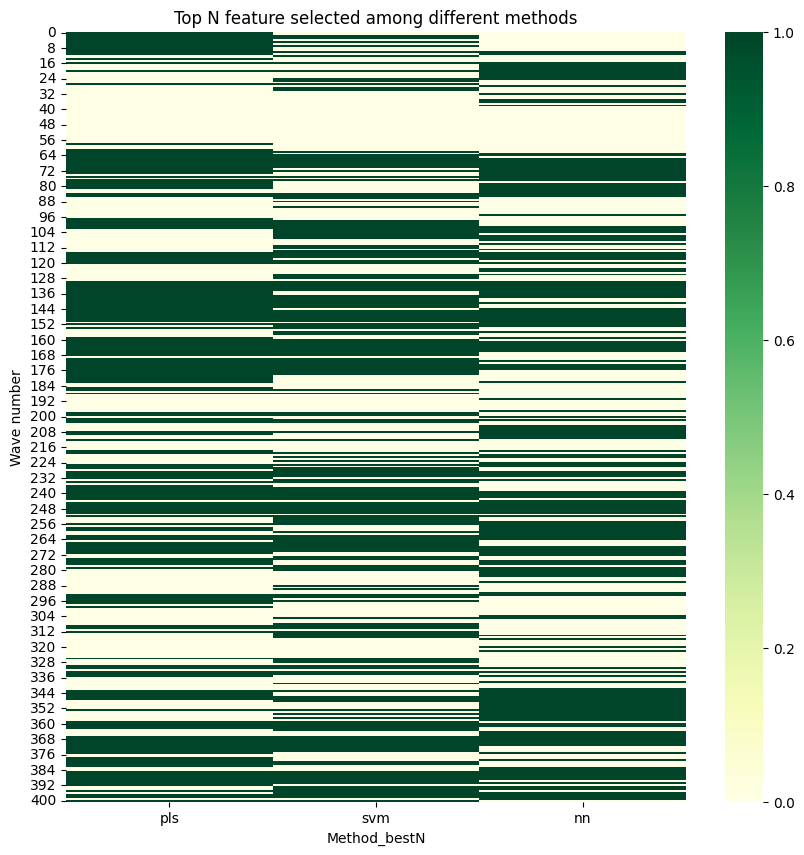

In [120]:
plt.style.use('default')
plt.figure(figsize=(10, 10))
sns.heatmap(data, annot=False, cmap="YlGn")
plt.title('Top N feature selected among different methods')
plt.xlabel('Method_bestN')
plt.ylabel('Wave number')
plt.show()


##### PLS muatual info best n_components for top_n variables

In [11]:
def pls_mutual_info_find_best(x_train, y_train, x_test, y_test, step, k_folds):
    columns = ['top_n', 'CV', 'train', 'test mse', 'n_components']
    stored = pd.DataFrame(columns=columns)
    
    mi_scores = mutual_info_regression(x_train, y_train, n_neighbors=3)
    
    for features in tqdm(np.arange(150, 1, -step)):
        important_idx = pd.Series(mi_scores).sort_values(ascending=False).head(features).index.sort_values()
        
        # Selecting the important features and then sorting the columns by their names to ensure consistent order
        x_train_important = x_train.iloc[:, important_idx].sort_index(axis=1)
        x_test_important = x_test.iloc[:, important_idx].sort_index(axis=1)
        
        kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
        
        best_CV = np.inf
        best_n_components = 0
        
        for latent_variables in range(1, features+1):
            val_mse_fold = []
            
            for _, (train_idx, val_idx) in enumerate(kfold.split(x_train_important)):
                # Sorting the indices to ensure consistent ordering
                train_idx_sorted = np.sort(train_idx)
                val_idx_sorted = np.sort(val_idx)
                
                x_train_fold = x_train_important.iloc[train_idx_sorted]
                y_train_fold = y_train.iloc[train_idx_sorted]
                x_val_fold = x_train_important.iloc[val_idx_sorted]
                y_val_fold = y_train.iloc[val_idx_sorted]
                
                pls = PLSRegression(n_components=latent_variables)
                pls.fit(x_train_fold, y_train_fold)
                
                val_loss_single_fold = mean_squared_error(y_val_fold, pls.predict(x_val_fold))
                val_mse_fold.append(val_loss_single_fold)
            
            avg_loss_val_fold = np.mean(val_mse_fold)
            
            if avg_loss_val_fold < best_CV:  # Update best
                best_CV = avg_loss_val_fold
                best_n_components = latent_variables
                
        pls = PLSRegression(n_components=best_n_components)
        pls.fit(x_train_important, y_train)
        
        train_loss = mean_squared_error(y_train, pls.predict(x_train_important))
        test_loss = mean_squared_error(y_test, pls.predict(x_test_important))
        
        stored.loc[features] = [features, best_CV, train_loss, test_loss, best_n_components]
        
    return stored

In [72]:
table=pls_mutual_info_find_best(x_train=x_train,
                                 y_train=y_train,
                                 x_test=x_test,
                                 y_test=y_test,
                                 step=1,
                                 k_folds=5)

100%|██████████| 149/149 [24:19<00:00,  9.80s/it] 


In [73]:
table

,top_n,CV,train,test mse,n_components
150,150.0,0.064845,0.035006,0.039005,21.0
149,149.0,0.064772,0.041759,0.044866,17.0
148,148.0,0.063601,0.035206,0.036464,21.0
147,147.0,0.063332,0.035276,0.036538,21.0
146,146.0,0.065389,0.035526,0.037119,21.0
...,...,...,...,...,...
6,6.0,0.348101,0.330051,0.341696,4.0
5,5.0,0.349371,0.331654,0.350408,4.0
4,4.0,0.386483,0.378958,0.331689,3.0
3,3.0,0.409197,0.399416,0.327743,3.0


In [74]:
#write in memory...
df=pd.DataFrame(table)
dir_path='C:\\Users\\lucas\\Downloads'

os.makedirs(dir_path,exist_ok=True)
file_path=os.path.join(dir_path,'table_top_n__best_n_components_pls_mutual_info_150_to_1')
df.to_csv(file_path, index=False)

In [100]:
df1=pd.read_csv("C:\\Users\\lucas\\Downloads\\table_top_n__best_n_components_pls_mutual_info.csv")
df2=pd.read_csv("C:\\Users\\lucas\\Downloads\\table_top_n__best_n_components_pls_mutual_info_150_to_1.csv")
table=pd.concat([df1,df2])

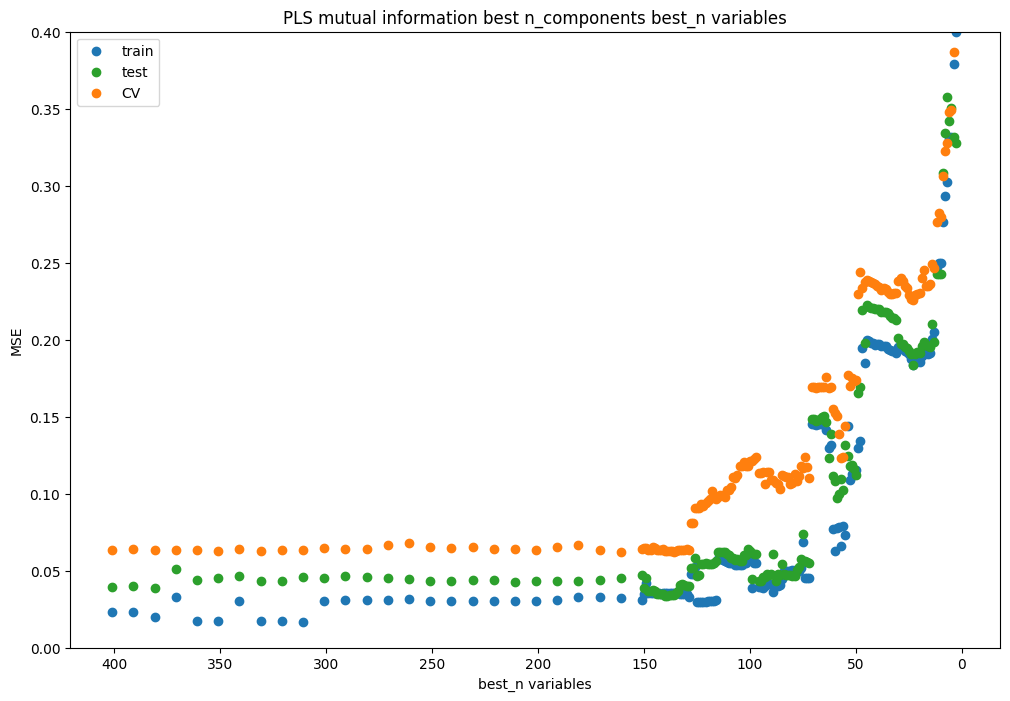

In [102]:
plt.figure(figsize=(12,8))

plt.scatter(df2['top_n'], df2['train'], color='C0', marker='o', label='train')
plt.scatter(df1['top_n'], df1['train'], color='C0', marker='o')

plt.scatter(df2['top_n'], df2['test mse'], color='C2', marker='o', label='test')
plt.scatter(df1['top_n'], df1['test mse'], color='C2', marker='o')

plt.scatter(df2['top_n'], df2['CV'], color='C1', marker='o', label='CV')
plt.scatter(df1['top_n'], df1['CV'], color='C1', marker='o')

plt.ylim(0,0.4)
plt.gca().invert_xaxis()

plt.ylabel('MSE')
plt.xlabel('best_n variables')
plt.title('PLS mutual information best n_components best_n variables')

plt.legend()


Text(0.5, 1.0, 'PLS mutual information best n_components best_n variables')

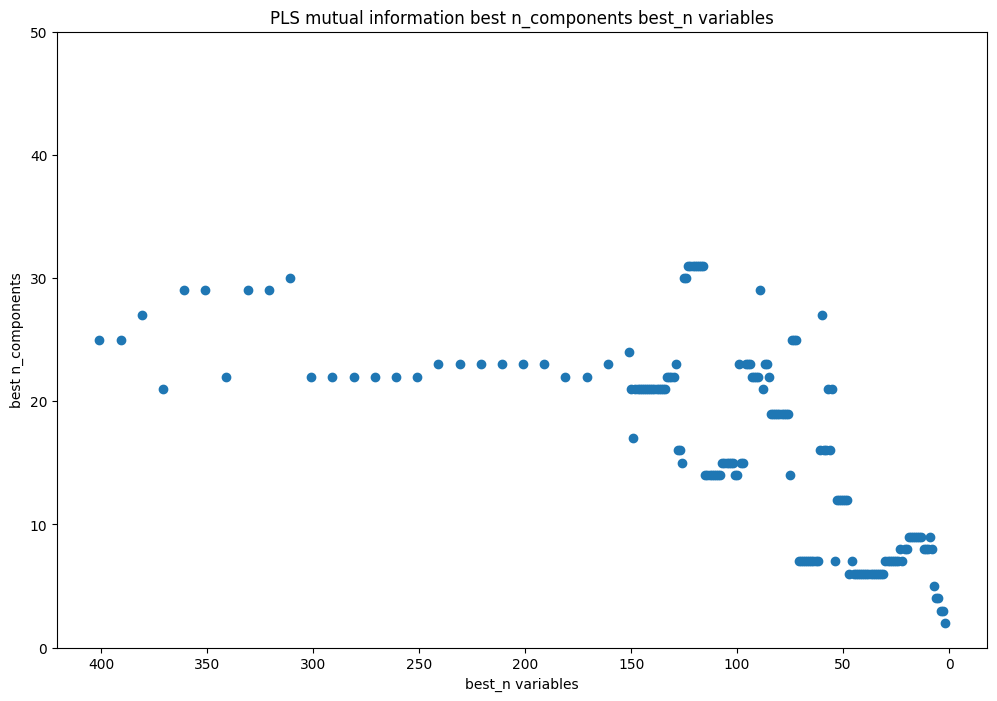

In [104]:
plt.figure(figsize=(12,8))

plt.scatter(df2['top_n'], df2['n_components'], color='C0', marker='o')
plt.scatter(df1['top_n'], df1['n_components'], color='C0', marker='o')

plt.ylim(0,50)
plt.gca().invert_xaxis()

plt.ylabel('best n_components')
plt.xlabel('best_n variables')
plt.title('PLS mutual information best n_components best_n variables')


##### SVM mutual information

In [182]:
def build_table_mutual_info_svm(x_train, y_train, x_test, y_test, step, k_folds, latent_variables):
    np.random.seed(42)
    columns = ['train mse', 'train std', 'val mse', 'val std', 'calibration mse', 'test mse']
    stored = pd.DataFrame(columns=columns)

    # Compute mutual information scores
    mi_scores = mutual_info_regression(x_train, y_train, n_neighbors=3)
    feature_indices = pd.Series(mi_scores).sort_values(ascending=False).index

    for features in np.arange(401, 399, -step):
        # Select the top 'features' based on mutual information scores
        important_idx = feature_indices[:features]

        # Use the important indices to subset the features
        x_train_filtered = x_train.iloc[:, important_idx]
        x_test_filtered = x_test.iloc[:, important_idx]

        # Setup cross-validation
        kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
        train_mse_fold = []
        val_mse_fold = []

        for train_idx, val_idx in kfold.split(x_train_filtered):
            x_train_fold = x_train_filtered.iloc[train_idx]
            y_train_fold = y_train.iloc[train_idx]
            x_val_fold = x_train_filtered.iloc[val_idx]
            y_val_fold = y_train.iloc[val_idx]

            # Train the model on the training fold
            svm = SVR(kernel='linear')
            svm.fit(x_train_fold, y_train_fold)

            # Compute MSE for the training and validation folds
            train_loss_single_fold = mean_squared_error(y_train_fold, svm.predict(x_train_fold))
            val_loss_single_fold = mean_squared_error(y_val_fold, svm.predict(x_val_fold))

            train_mse_fold.append(train_loss_single_fold)
            val_mse_fold.append(val_loss_single_fold)

        # Train and evaluate the model on the complete train and test datasets
        svm_full = SVR(kernel='linear')
        svm_full.fit(x_train_filtered, y_train)
        train_loss = mean_squared_error(y_train, svm_full.predict(x_train_filtered))
        test_loss = mean_squared_error(y_test, svm_full.predict(x_test_filtered))

        # Store results
        stored.loc[features] = [
            np.mean(train_mse_fold), np.std(train_mse_fold),
            np.mean(val_mse_fold), np.std(val_mse_fold),
            train_loss, test_loss
        ]

    return stored

In [185]:
table=build_table_mutual_info_svm(x_train, y_train, x_test, y_test, 1, 5, 10)

In [186]:
table

,train mse,train std,val mse,val std,calibration mse,test mse
401,0.039292,0.002295,0.067363,0.006696,0.039808,0.05206
400,0.039310,0.002292,0.067411,0.006613,0.039869,0.05210


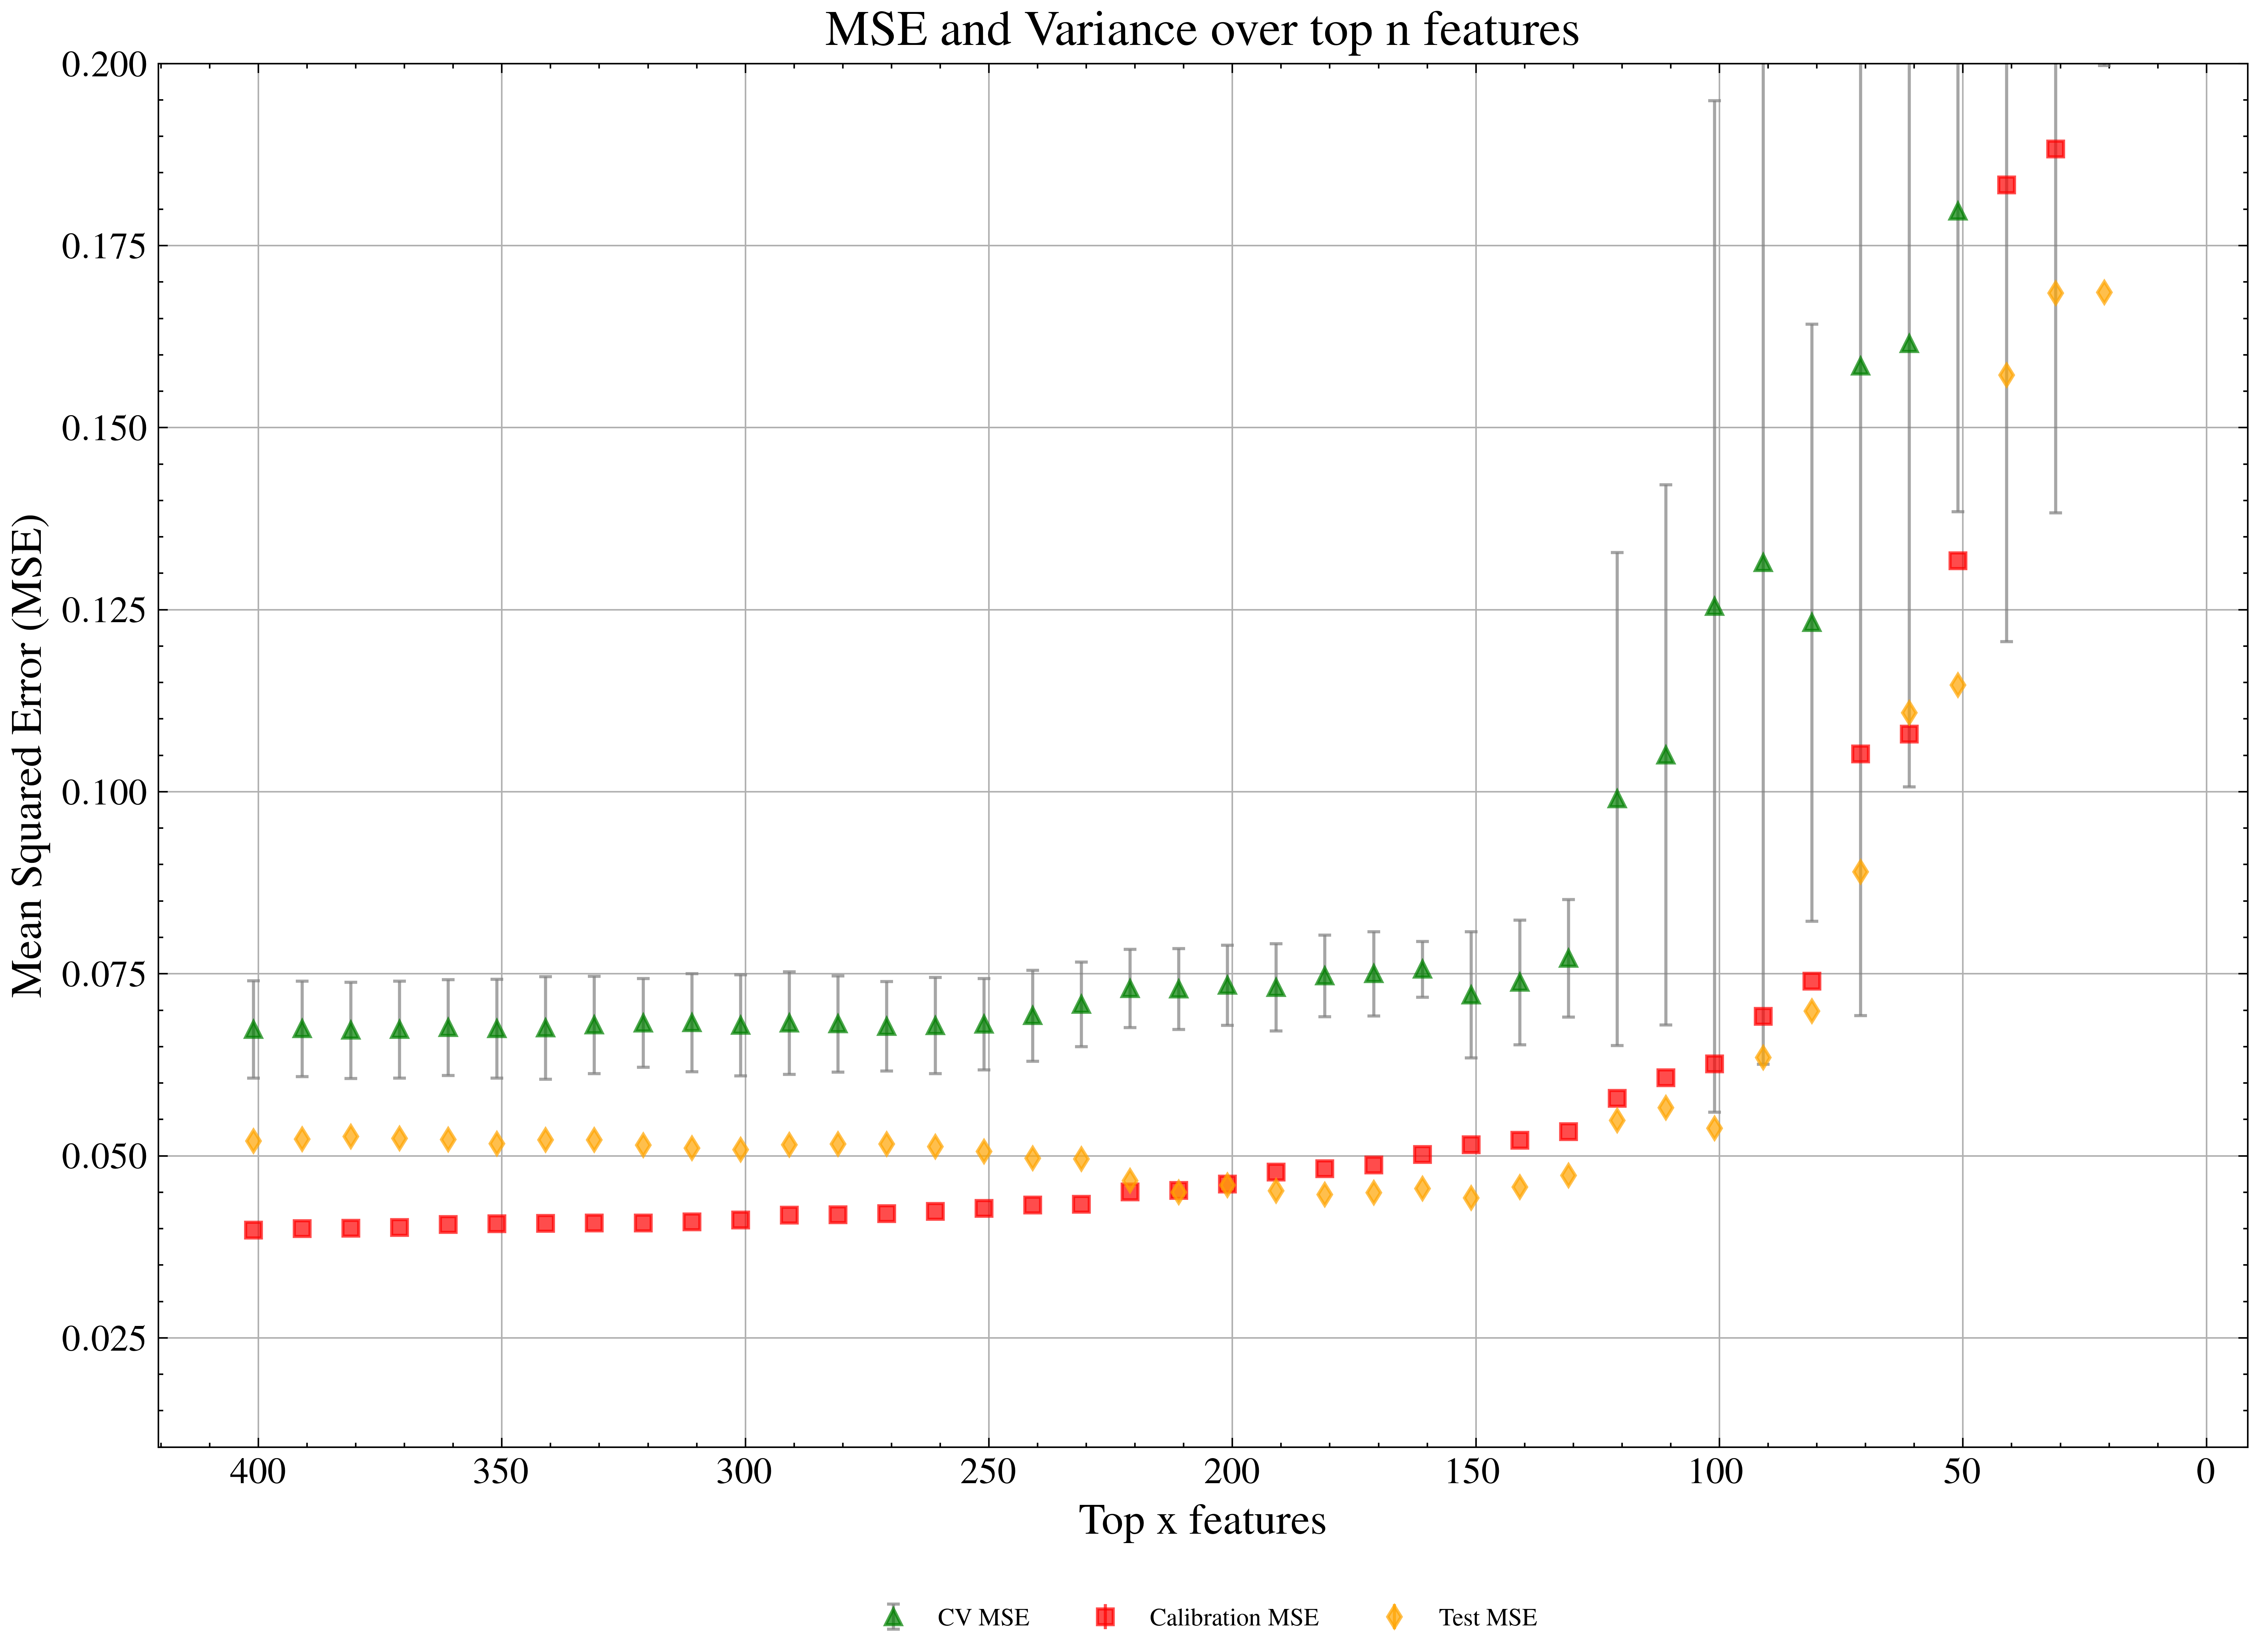

In [79]:
import scienceplots
plt.style.use('science')
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

#plt.errorbar(table.index[::-1], table['train mse'][::-1], yerr=table['train std'][::-1], fmt='o', markersize=5, capsize=2, label='Train MSE', color='blue', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['val mse'][::-1], yerr=table['val std'][::-1], fmt='^', markersize=5, capsize=2, label='CV MSE', color='green', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['calibration mse'][::-1], yerr=0, fmt='s', markersize=5, label='Calibration MSE', color='red', alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['test mse'][::-1], yerr=0, fmt='d', markersize=5, label='Test MSE', color='orange', alpha=0.7, linestyle='')

plt.xlabel('Top x features', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.title('MSE and Variance over top n features', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4)
plt.ylim(0.01,0.2)
plt.gca().invert_xaxis()  # Keep the x-axis inverted

plt.show()

##### SVM permutation importance

In [214]:
#function to evaluate permutation importance, evaluate on every fold, also stores learning curves...
def permutation_importance_svm(X_train,y_train,k_folds):
    
    if not isinstance(X_train, pd.DataFrame):
        try:
            X_train = pd.DataFrame(X_train)
        except ValueError:
            print("X cannot be converted to a pandas DataFrame.")
    
    if not isinstance(y_train, pd.Series):
        try:
            y_train = pd.Series(y_train)
        except ValueError:
            print("X cannot be converted to a pandas Series.")        
               
    kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)

    cross_importances=np.zeros((x_train.shape[1],kfold.n_splits))

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        
        x_train_fold=X_train.iloc[np.sort(train_idx)]
        y_train_fold=y_train.iloc[np.sort(train_idx)]
        x_val_fold=X_train.iloc[np.sort(val_idx)]
        y_val_fold=y_train.iloc[np.sort(val_idx)]
        
        svm=SVR(kernel='linear')
        svm.fit(x_train_fold,y_train_fold)
        
        results = permutation_importance(svm,
                                        x_val_fold,
                                        y_val_fold,
                                        n_repeats=30,
                                        random_state=42,
                                        n_jobs=4,
                                        scoring='neg_mean_squared_error')
        
        cross_importances[:,fold]=results.importances_mean
        
    return cross_importances

In [229]:
def build_table_svm(x_train,y_train,x_test,y_test,step,perm_imp_array,k_folds):
    #here i used the terms calibration and train somewhat interchangeably
    #the idea is that the complete train set without fold separation to be called calibration
    #the fold used to generate the model is train and the fold used to validade is validation...
    columns=['train mse','train std','val mse','val std','calibration mse','test mse']
    stored = pd.DataFrame(columns=columns)

    for features in np.arange(401,1,-step):
        
        important_idx=perm_imp_get_topn_indexes(perm_imp_output=perm_imp_array,
                                                top_n=features)
    
        x_train_reduced=x_train[important_idx.sort_values()]
        x_test_reduced=x_test[important_idx.sort_values()]
        
        kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)
        
        train_mse_fold=[]
        val_mse_fold=[]
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train_reduced)):
        
            x_train_fold=x_train_reduced.iloc[np.sort(train_idx)]
            y_train_fold=y_train.iloc[np.sort(train_idx)]
            x_val_fold=x_train_reduced.iloc[np.sort(val_idx)]
            y_val_fold=y_train.iloc[np.sort(val_idx)]
            
            svm=SVR(kernel='linear')
            svm.fit(x_train_fold,y_train_fold)
            
            train_loss_single_fold=mean_squared_error(y_train_fold,svm.predict(x_train_fold))
            val_loss_single_fold=mean_squared_error(y_val_fold,svm.predict(x_val_fold))
            
            train_mse_fold.append(train_loss_single_fold)
            val_mse_fold.append(val_loss_single_fold)
        

        svm=SVR(kernel='linear')
        svm.fit(x_train_reduced,y_train)
        
        train_loss=mean_squared_error(y_train,svm.predict(x_train_reduced))
        test_loss=mean_squared_error(y_test,svm.predict(x_test_reduced))
    
        #['avg train mse','std train mse,'avg val mse','std val mse','calibration mse','test mse']
        avg_loss_train_fold=np.mean(train_mse_fold)
        std_loss_train_fold=np.std(train_mse_fold)
        avg_loss_val_fold=np.mean(val_mse_fold)
        std_loss_val_fold=np.std(val_mse_fold)
        
        stored.loc[features] = [avg_loss_train_fold,
                                std_loss_train_fold,
                                avg_loss_val_fold,
                                std_loss_val_fold,
                                train_loss,
                                test_loss]
            
    return stored

In [230]:
importances_svm=permutation_importance_svm(X_train=x_train,
                                           y_train=y_train,
                                           k_folds=5)

In [231]:
importance_rank=pd.DataFrame(importances_svm).rank(ascending=False)
importance_rank_named=importance_rank.rename(columns={0:'fold1',1:'fold2',2:'fold3',3:'fold4',4:'fold5'})
importance_overall_rank_svm=importance_rank_named.median(axis=1) #using median is more robust to outliers 

In [232]:
check_intersections(importance_rank_named,200)

,fold1,fold2,fold3,fold4,fold5
fold1,1.000,0.680,0.785,0.680,0.710
fold2,0.680,1.000,0.695,0.685,0.655
fold3,0.785,0.695,1.000,0.685,0.750
fold4,0.680,0.685,0.685,1.000,0.715
fold5,0.710,0.655,0.750,0.715,1.000


In [234]:
table= build_table_svm(x_train=x_train,
                        y_train=y_train,
                       x_test=x_test,
                       y_test=y_test,
                       step=100,
                       perm_imp_array=importance_overall_rank_svm,
                       k_folds=5)

In [235]:
table

,train mse,train std,val mse,val std,calibration mse,test mse
401,0.039292,0.002295,0.067363,0.006696,0.039808,0.052060
301,0.039569,0.002157,0.064568,0.006194,0.040083,0.052100
201,0.040448,0.001959,0.062307,0.006308,0.040851,0.051337
101,0.044745,0.001980,0.067557,0.006573,0.044965,0.051678


##### SVM mrmr

In [165]:
def build_table_mrmr_svm(x_train, y_train, x_test, y_test, step, k_folds, latent_variables):
    np.random.seed(42)
    columns = ['train mse', 'train std', 'val mse', 'val std', 'calibration mse', 'test mse']
    stored = pd.DataFrame(columns=columns)

    # Compute mutual information scores
    selected_features=mrmr_regression(X=x_train,
                                      y=y_train,
                                      K=401)
    
    for features in tqdm(np.arange(401, 398, -step)):
        
        important_idx=selected_features[0:features]

        # Use the important indices to subset the features
        x_train_filtered = x_train.iloc[:, important_idx]
        x_test_filtered = x_test.iloc[:, important_idx]

        # Setup cross-validation
        kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
        train_mse_fold = []
        val_mse_fold = []

        for train_idx, val_idx in kfold.split(x_train_filtered):
            x_train_fold = x_train_filtered.iloc[train_idx]
            y_train_fold = y_train.iloc[train_idx]
            x_val_fold = x_train_filtered.iloc[val_idx]
            y_val_fold = y_train.iloc[val_idx]
            
            # Train the model on the training fold
            svm = SVR(kernel='linear')
            svm.fit(x_train_fold, y_train_fold)

            # Compute MSE for the training and validation folds
            train_loss_single_fold = mean_squared_error(y_train_fold, svm.predict(x_train_fold))
            val_loss_single_fold = mean_squared_error(y_val_fold, svm.predict(x_val_fold))

            train_mse_fold.append(train_loss_single_fold)
            val_mse_fold.append(val_loss_single_fold)

        # Train and evaluate the model on the complete train and test datasets
        svm_full = SVR(kernel='linear')
        svm_full.fit(x_train_filtered, y_train)
        train_loss = mean_squared_error(y_train, svm_full.predict(x_train_filtered))
        test_loss = mean_squared_error(y_test, svm_full.predict(x_test_filtered))

        # Store results
        stored.loc[features] = [
            np.mean(train_mse_fold), np.std(train_mse_fold),
            np.mean(val_mse_fold), np.std(val_mse_fold),
            train_loss, test_loss
        ]

    return stored

In [166]:
table=build_table_mrmr_svm(x_train, y_train, x_test, y_test, 1, 5, 10)

100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


In [238]:
table

,train mse,train std,val mse,val std,calibration mse,test mse
401,0.039292,0.002295,0.067363,0.006696,0.039808,0.052060
400,0.039291,0.002250,0.067135,0.006888,0.039795,0.052381
399,0.039295,0.002239,0.066823,0.006442,0.039770,0.052406


##### SVM MI

In [29]:
def build_table_MI_svm(x_train, y_train, x_test, y_test, step, k_folds):
    np.random.seed(42)
    columns = ['train mse', 'train std', 'CV r2', 'CV stdev', 'calibration r2', 'test r2']
    stored = pd.DataFrame(columns=columns)

    # Compute mutual information scores
    mi_scores=mutual_info_regression(x_train,y_train,n_neighbors=3)
    
    for features in tqdm(np.arange(401, 30, -step)):
        
        important_idx=pd.Series(mi_scores).sort_values(ascending=False).head(features).index

        # Use the important indices to subset the features
        x_train_filtered = x_train.iloc[:, important_idx]
        x_test_filtered = x_test.iloc[:, important_idx]

        # Setup cross-validation
        kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
        train_mse_fold = []
        val_mse_fold = []

        for train_idx, val_idx in kfold.split(x_train_filtered):
            x_train_fold = x_train_filtered.iloc[train_idx]
            y_train_fold = y_train.iloc[train_idx]
            x_val_fold = x_train_filtered.iloc[val_idx]
            y_val_fold = y_train.iloc[val_idx]
            
            # Train the model on the training fold
            svm = SVR(kernel='linear')
            svm.fit(x_train_fold, y_train_fold)

            # Compute MSE for the training and validation folds
            train_loss_single_fold = r2_score(y_train_fold, svm.predict(x_train_fold))
            val_loss_single_fold = r2_score(y_val_fold, svm.predict(x_val_fold))

            train_mse_fold.append(train_loss_single_fold)
            val_mse_fold.append(val_loss_single_fold)

        # Train and evaluate the model on the complete train and test datasets
        svm_full = SVR(kernel='linear')
        svm_full.fit(x_train_filtered, y_train)
        train_loss = r2_score(y_train, svm_full.predict(x_train_filtered))
        test_loss = r2_score(y_test, svm_full.predict(x_test_filtered))

        # Store results
        stored.loc[features] = [
            np.mean(train_mse_fold), np.std(train_mse_fold),
            np.mean(val_mse_fold), np.std(val_mse_fold),
            train_loss, test_loss
        ]

    return stored

In [30]:
table=build_table_MI_svm(x_train=x_train,
                         y_train=y_train,
                         x_test=x_test,
                         y_test=y_test,
                         step=10,
                         k_folds=5)

100%|██████████| 38/38 [00:28<00:00,  1.32it/s]


In [32]:
table

,train mse,train std,CV r2,CV stdev,calibration r2,test r2
401,0.960652,0.002569,0.930857,0.010820,0.960192,0.943372
391,0.960526,0.002625,0.930734,0.010993,0.959985,0.943096
381,0.960495,0.002546,0.930940,0.011049,0.959921,0.942703
371,0.960367,0.002548,0.930836,0.011068,0.959857,0.943007
361,0.959850,0.002461,0.930802,0.009392,0.959454,0.943152
351,0.959662,0.002457,0.931009,0.009029,0.959348,0.943774
341,0.959560,0.002424,0.930958,0.009021,0.959257,0.943243
331,0.959448,0.002486,0.930452,0.009466,0.959238,0.943232
321,0.959283,0.002541,0.930045,0.009943,0.959219,0.943995
311,0.958788,0.002441,0.930206,0.008884,0.959049,0.944471


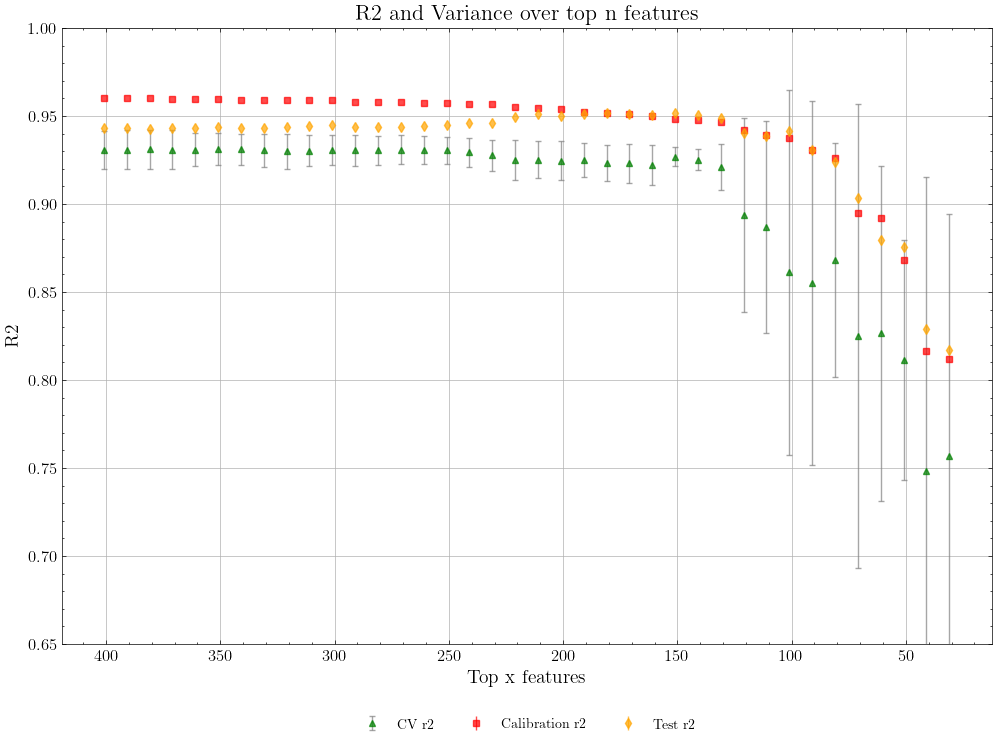

In [35]:
import scienceplots
plt.style.use('science')
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

#plt.errorbar(table.index[::-1], table['train mse'][::-1], yerr=table['train std'][::-1], fmt='o', markersize=5, capsize=2, label='Train MSE', color='blue', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['CV r2'][::-1], yerr=table['CV stdev'][::-1], fmt='^', markersize=5, capsize=2, label='CV r2', color='green', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['calibration r2'][::-1], yerr=0, fmt='s', markersize=5, label='Calibration r2', color='red', alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['test r2'][::-1], yerr=0, fmt='d', markersize=5, label='Test r2', color='orange', alpha=0.7, linestyle='')

plt.xlabel('Top x features', fontsize=14)
plt.ylabel('R2', fontsize=14)
plt.title('R2 and Variance over top n features', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4)
plt.ylim(0.65,1)
plt.gca().invert_xaxis()  # Keep the x-axis inverted

plt.show()

##### SVM permutation importance

In [64]:
#function to evaluate permutation importance, evaluate on every fold, also stores learning curves...
def permutation_importance_svm(X_train,y_train,k_folds):
    
    if not isinstance(X_train, pd.DataFrame):
        try:
            X_train = pd.DataFrame(X_train)
        except ValueError:
            print("X cannot be converted to a pandas DataFrame.")
    
    if not isinstance(y_train, pd.Series):
        try:
            y_train = pd.Series(y_train)
        except ValueError:
            print("X cannot be converted to a pandas Series.")        
               
    kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)

    cross_importances=np.zeros((x_train.shape[1],kfold.n_splits))

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        
        x_train_fold=X_train.iloc[np.sort(train_idx)]
        y_train_fold=y_train.iloc[np.sort(train_idx)]
        x_val_fold=X_train.iloc[np.sort(val_idx)]
        y_val_fold=y_train.iloc[np.sort(val_idx)]
        
        svm=SVR(kernel='linear')
        svm.fit(x_train_fold,y_train_fold)
        
        results = permutation_importance(svm,
                                        x_val_fold,
                                        y_val_fold,
                                        n_repeats=30,
                                        random_state=42,
                                        n_jobs=4,
                                        scoring='neg_mean_squared_error')
        
        cross_importances[:,fold]=results.importances_mean
        
    return cross_importances

In [ ]:
def build_table_pls(x_train,y_train,x_test,y_test,step,perm_imp_array,k_folds,latent_variables):
    #here i used the terms calibration and train somewhat interchangeably
    #the idea is that the complete train set without fold separation to be called calibration
    #the fold used to generate the model is train and the fold used to validade is validation...
    columns=['train mse','train std','val mse','val std','calibration mse','test mse']
    stored = pd.DataFrame(columns=columns)

    for features in np.arange(401,399,-step):
        
        important_idx=perm_imp_get_topn_indexes(perm_imp_output=perm_imp_array,
                                                top_n=features)
    
        x_train_reduced=x_train[important_idx.sort_values()]
        x_test_reduced=x_test[important_idx.sort_values()]
        
        kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)
        
        train_mse_fold=[]
        val_mse_fold=[]
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train_reduced)):
        
            x_train_fold=x_train_reduced.iloc[np.sort(train_idx)]
            y_train_fold=y_train.iloc[np.sort(train_idx)]
            x_val_fold=x_train_reduced.iloc[np.sort(val_idx)]
            y_val_fold=y_train.iloc[np.sort(val_idx)]
            
            pls=PLSRegression(n_components=latent_variables)
            pls.fit(x_train_fold,y_train_fold)
            
            train_loss_single_fold=mean_squared_error(y_train_fold,pls.predict(x_train_fold))
            val_loss_single_fold=mean_squared_error(y_val_fold,pls.predict(x_val_fold))
            
            train_mse_fold.append(train_loss_single_fold)
            val_mse_fold.append(val_loss_single_fold)
        

        pls=PLSRegression(n_components=latent_variables)
        pls.fit(x_train_reduced,y_train)
        
        train_loss=mean_squared_error(y_train,pls.predict(x_train_reduced))
        test_loss=mean_squared_error(y_test,pls.predict(x_test_reduced))
    
        #['avg train mse','std train mse,'avg val mse','std val mse','calibration mse','test mse']
        avg_loss_train_fold=np.mean(train_mse_fold)
        std_loss_train_fold=np.std(train_mse_fold)
        avg_loss_val_fold=np.mean(val_mse_fold)
        std_loss_val_fold=np.std(val_mse_fold)
        
        stored.loc[features] = [avg_loss_train_fold,
                                std_loss_train_fold,
                                avg_loss_val_fold,
                                std_loss_val_fold,
                                train_loss,
                                test_loss]
            
    return stored

In [66]:
importances_svm=permutation_importance_svm(X_train=x_train,
                                           y_train=y_train,
                                           k_folds=5)
importance_rank=pd.DataFrame(importances_svm).rank(ascending=False)
importance_rank_named=importance_rank.rename(columns={0:'fold1',1:'fold2',2:'fold3',3:'fold4',4:'fold5'})
#importance_overall_rank=importance_rank_named.mean(axis=1)
importance_overall_rank_svm=importance_rank_named.median(axis=1) #using median is more robust to outliers 

##### PLS sequential feature selection

In [138]:
def pls_cross_val_score(X, y, n_components, cv=5):
    
    kf = KFold(n_splits=cv,shuffle=True,random_state=42)
    r2_scores = []

    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        pls = PLSRegression(n_components=n_components)
        pls.fit(X_train_fold, y_train_fold)
        y_val_pred = pls.predict(X_val_fold)
        r2 = r2_score(y_val_fold, y_val_pred)
        r2_scores.append(r2)

    return np.mean(r2_scores),r2_scores

In [136]:
def return_next_index_and_cv(X_train,y_train,already_selected):
    best_cv=0
    feature_to_enter=None
    best_n_components=None
    best_cv_list=None
    
    for feature in range(X_train.shape[1]):
        if feature not in already_selected:
            indexes=already_selected+[feature]
            x_train_sliced=X_train[:,indexes]
            
            if x_train_sliced.ndim == 1:
                x_train_sliced = x_train_sliced.reshape(-1, 1)
            
            max_n_components=min(x_train_sliced.shape[1],40)
            
            for n_components in range(1,max_n_components+1):
                cv,cv_list=pls_cross_val_score(X=x_train_sliced,
                                                y=y_train, 
                                                n_components=n_components, 
                                                cv=5)

                if np.mean(cv_list)>=best_cv:
                    best_cv=cv
                    feature_to_enter=feature
                    best_n_components=n_components
                    best_cv_list=cv_list
            
    return best_cv,feature_to_enter,best_n_components,best_cv_list

In [163]:
def sequential_feature_selection(X_train, y_train,X_test,y_test,pre_use_indexes):
    
    X_train=np.array(X_train)
    y_train=np.array(y_train)
    X_test=np.array(X_test)
    y_test=np.array(y_test)

    columns = ['CV r2', 'CV stdev', 'calibration r2', 'test r2','best_n_components','n_features']
    stored = pd.DataFrame(columns=columns)


    selected_indexes=pre_use_indexes
    for n_features in tqdm(range(30,101)):
        best_cv,feature_to_enter,best_n_components,best_cv_list=return_next_index_and_cv(X_train=X_train,
                                                                            y_train=y_train,
                                                                            already_selected=selected_indexes)
        
        selected_indexes.append(feature_to_enter)
        
        x_train_sliced=X_train[:,selected_indexes]
        x_test_sliced=X_test[:,selected_indexes]
        
        if x_train_sliced.ndim == 1:
            x_train_sliced = x_train_sliced.reshape(-1, 1)
            
        pls=PLSRegression(n_components=best_n_components)
        pls.fit(x_train_sliced,y_train)
        train_loss=r2_score(y_train,pls.predict(x_train_sliced))
        test_loss=r2_score(y_test,pls.predict(x_test_sliced))
        
        
        # Store results
        stored.loc[n_features] = [np.mean(best_cv_list), 
                                  np.std(best_cv_list),
                                  train_loss,
                                  test_loss,
                                  best_n_components,
                                  n_features]

    return stored,selected_indexes

In [167]:
table,indexes=sequential_feature_selection(X_train=x_train, 
                                           y_train=y_train,
                                           X_test=x_test,
                                           y_test=y_test,
                                           pre_use_indexes=indexes)

 24%|██▍       | 17/71 [2:54:42<9:14:56, 616.59s/it] 


KeyboardInterrupt: 

In [97]:
#write in memory...
df=pd.DataFrame(table)
dir_path='C:\\Users\\lucas\\Downloads'

os.makedirs(dir_path,exist_ok=True)
file_path=os.path.join(dir_path,'PLS_sequential_30_to_100')
df.to_csv(file_path, index=False)

In [160]:
df1=pd.read_csv("C:\\Users\\lucas\\Downloads\\PLS_sequential_order_29.csv")
df2=pd.read_csv("C:\\Users\\lucas\\Downloads\\PLS_sequential_1_to_29.csv")
table=pd.concat([df1,df2])

In [165]:
indexes=df1.iloc[:, 0].tolist()

In [166]:
len(indexes)

29

In [154]:
df2

,CV r2,CV stdev,calibration r2,test r2,best_n_components,n_features
0,0.148205,0.135790,0.184018,0.292948,1.0,1.0
1,0.716729,0.033755,0.728842,0.712746,2.0,2.0
2,0.754666,0.022368,0.767083,0.715559,3.0,3.0
3,0.777976,0.029036,0.790973,0.748583,4.0,4.0
4,0.796255,0.028742,0.813813,0.784225,5.0,5.0
5,0.859421,0.046330,0.871827,0.812219,6.0,6.0
6,0.871655,0.040425,0.883564,0.838880,7.0,7.0
7,0.877275,0.041191,0.893575,0.861117,8.0,8.0
8,0.881433,0.035756,0.898279,0.876104,9.0,9.0
9,0.903705,0.012944,0.919312,0.906081,10.0,10.0


##### SVM Sequential

In [6]:
def svm_cross_val_score(X, y, cv=5):
    
    kf = KFold(n_splits=cv,shuffle=True,random_state=42)
    r2_scores = []

    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        svm = SVR(kernel='linear')
        svm.fit(X_train_fold, y_train_fold)
        y_val_pred = svm.predict(X_val_fold)
        r2 = r2_score(y_val_fold, y_val_pred)
        r2_scores.append(r2)

    return np.mean(r2_scores),r2_scores

In [7]:
def return_next_index_and_cv(X_train,y_train,already_selected):
    best_cv=0
    feature_to_enter=None
    best_n_components=None
    best_cv_list=None
    
    for feature in range(X_train.shape[1]):
        if feature not in already_selected:
            indexes=already_selected+[feature]
            x_train_sliced=X_train[:,indexes]
            
            if x_train_sliced.ndim == 1:
                x_train_sliced = x_train_sliced.reshape(-1, 1)
                
            cv,cv_list=svm_cross_val_score(X=x_train_sliced,
                                           y=y_train, 
                                           cv=5)

            if np.mean(cv_list)>=best_cv:
                best_cv=cv
                feature_to_enter=feature
                best_cv_list=cv_list
            
    return best_cv,feature_to_enter,best_cv_list

In [12]:
def sequential_feature_selection(X_train, y_train,X_test,y_test,pre_use_indexes):
    
    X_train=np.array(X_train)
    y_train=np.array(y_train)
    X_test=np.array(X_test)
    y_test=np.array(y_test)

    columns = ['CV r2', 'CV stdev', 'calibration r2', 'test r2','n_features']
    stored = pd.DataFrame(columns=columns)


    selected_indexes=pre_use_indexes
    for n_features in tqdm(range(1,200)):
        best_cv,feature_to_enter,best_cv_list=return_next_index_and_cv(X_train=X_train,
                                                                       y_train=y_train,
                                                                       already_selected=selected_indexes)
        
        selected_indexes.append(feature_to_enter)
        
        x_train_sliced=X_train[:,selected_indexes]
        x_test_sliced=X_test[:,selected_indexes]
        
        if x_train_sliced.ndim == 1:
            x_train_sliced = x_train_sliced.reshape(-1, 1)
            
        svm=SVR(kernel='linear')
        svm.fit(x_train_sliced,y_train)
        train_loss=r2_score(y_train,svm.predict(x_train_sliced))
        test_loss=r2_score(y_test,svm.predict(x_test_sliced))
        
        
        # Store results
        stored.loc[n_features] = [np.mean(best_cv_list), 
                                  np.std(best_cv_list),
                                  train_loss,
                                  test_loss,
                                  n_features]

    return stored,selected_indexes

In [13]:
table,indexes=sequential_feature_selection(X_train=x_train, 
                                           y_train=y_train,
                                           X_test=x_test,
                                           y_test=y_test,
                                           pre_use_indexes=[])

100%|██████████| 199/199 [4:33:13<00:00, 82.38s/it]   


In [15]:
#write in memory...
df=pd.DataFrame(indexesaa)
dir_path='C:\\Users\\lucas\\Downloads'

os.makedirs(dir_path,exist_ok=True)
file_path=os.path.join(dir_path,'sequential_svm_order_up_to_199.csv')
df.to_csv(file_path, index=False)

In [121]:
df1=pd.read_csv('C:\\Users\\lucas\\Downloads\\PLS_sequential_1_to_29.csv')
indexes=pd.read_csv('C:\\Users\\lucas\\Downloads\\sequential_svm_order_up_to_199.csv')

In [122]:
table=df1

In [123]:
table

,CV r2,CV stdev,calibration r2,test r2,best_n_components,n_features
0,0.148205,0.135790,0.184018,0.292948,1.0,1.0
1,0.716729,0.033755,0.728842,0.712746,2.0,2.0
2,0.754666,0.022368,0.767083,0.715559,3.0,3.0
3,0.777976,0.029036,0.790973,0.748583,4.0,4.0
4,0.796255,0.028742,0.813813,0.784225,5.0,5.0
5,0.859421,0.046330,0.871827,0.812219,6.0,6.0
6,0.871655,0.040425,0.883564,0.838880,7.0,7.0
7,0.877275,0.041191,0.893575,0.861117,8.0,8.0
8,0.881433,0.035756,0.898279,0.876104,9.0,9.0
9,0.903705,0.012944,0.919312,0.906081,10.0,10.0


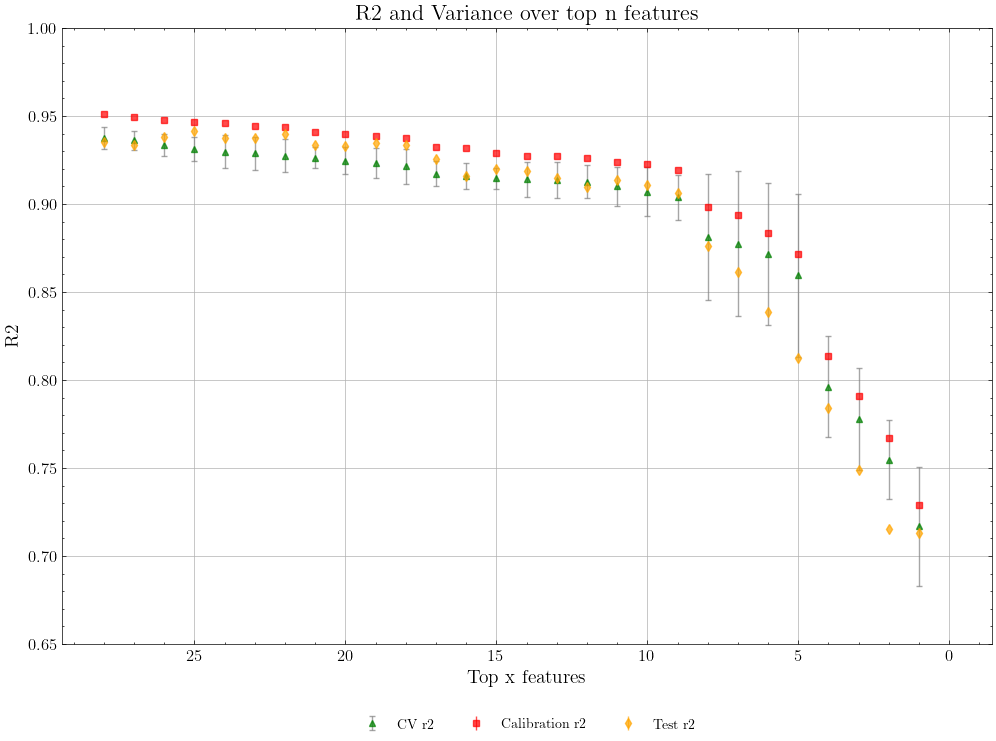

In [124]:
import scienceplots
plt.style.use('science')
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

#plt.errorbar(table.index[::-1], table['train mse'][::-1], yerr=table['train std'][::-1], fmt='o', markersize=5, capsize=2, label='Train MSE', color='blue', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['CV r2'][::-1], yerr=table['CV stdev'][::-1], fmt='^', markersize=5, capsize=2, label='CV r2', color='green', ecolor='gray', elinewidth=1, alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['calibration r2'][::-1], yerr=0, fmt='s', markersize=5, label='Calibration r2', color='red', alpha=0.7, linestyle='')
plt.errorbar(table.index[::-1], table['test r2'][::-1], yerr=0, fmt='d', markersize=5, label='Test r2', color='orange', alpha=0.7, linestyle='')

plt.xlabel('Top x features', fontsize=14)
plt.ylabel('R2', fontsize=14)
plt.title('R2 and Variance over top n features', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4)
plt.ylim(0.65,1)
plt.gca().invert_xaxis()  # Keep the x-axis inverted

plt.show()

In [49]:
indexes_list=indexes.values.tolist()
flat_list = [item for sublist in indexes_list for item in sublist]

In [51]:
flat_list

[144,
 168,
 246,
 400,
 250,
 131,
 318,
 141,
 147,
 396,
 242,
 70,
 372,
 239,
 175,
 270,
 299,
 313,
 138,
 166,
 249,
 170,
 140,
 139,
 337,
 331,
 243,
 169,
 326,
 335,
 325,
 334,
 324,
 329,
 143,
 330,
 305,
 97,
 332,
 98,
 333,
 99,
 103,
 105,
 107,
 310,
 142,
 108,
 304,
 312,
 297,
 164,
 247,
 289,
 263,
 353,
 345,
 115,
 314,
 339,
 316,
 112,
 302,
 309,
 268,
 328,
 288,
 235,
 240,
 290,
 91,
 234,
 167,
 111,
 104,
 114,
 306,
 171,
 303,
 100,
 116,
 296,
 182,
 165,
 237,
 113,
 261,
 264,
 308,
 307,
 301,
 102,
 323,
 251,
 262,
 106,
 300,
 101,
 311,
 109,
 322,
 321,
 336,
 96,
 319,
 110,
 340,
 160,
 359,
 399,
 118,
 352,
 338,
 317,
 158,
 92,
 344,
 315,
 159,
 291,
 117,
 93,
 320,
 342,
 350,
 267,
 343,
 162,
 294,
 287,
 86,
 265,
 94,
 356,
 95,
 266,
 351,
 292,
 90,
 347,
 355,
 88,
 397,
 145,
 67,
 120,
 393,
 362,
 293,
 89,
 119,
 233,
 84,
 87,
 354,
 83,
 252,
 177,
 286,
 85,
 295,
 82,
 298,
 80,
 236,
 269,
 161,
 341,
 360,
 81,
 1

In [53]:
for i in range(0,401):
    if i not in flat_list:
        flat_list.append(i)

In [54]:
flat_list

[144,
 168,
 246,
 400,
 250,
 131,
 318,
 141,
 147,
 396,
 242,
 70,
 372,
 239,
 175,
 270,
 299,
 313,
 138,
 166,
 249,
 170,
 140,
 139,
 337,
 331,
 243,
 169,
 326,
 335,
 325,
 334,
 324,
 329,
 143,
 330,
 305,
 97,
 332,
 98,
 333,
 99,
 103,
 105,
 107,
 310,
 142,
 108,
 304,
 312,
 297,
 164,
 247,
 289,
 263,
 353,
 345,
 115,
 314,
 339,
 316,
 112,
 302,
 309,
 268,
 328,
 288,
 235,
 240,
 290,
 91,
 234,
 167,
 111,
 104,
 114,
 306,
 171,
 303,
 100,
 116,
 296,
 182,
 165,
 237,
 113,
 261,
 264,
 308,
 307,
 301,
 102,
 323,
 251,
 262,
 106,
 300,
 101,
 311,
 109,
 322,
 321,
 336,
 96,
 319,
 110,
 340,
 160,
 359,
 399,
 118,
 352,
 338,
 317,
 158,
 92,
 344,
 315,
 159,
 291,
 117,
 93,
 320,
 342,
 350,
 267,
 343,
 162,
 294,
 287,
 86,
 265,
 94,
 356,
 95,
 266,
 351,
 292,
 90,
 347,
 355,
 88,
 397,
 145,
 67,
 120,
 393,
 362,
 293,
 89,
 119,
 233,
 84,
 87,
 354,
 83,
 252,
 177,
 286,
 85,
 295,
 82,
 298,
 80,
 236,
 269,
 161,
 341,
 360,
 81,
 1